# Energy Analytics for Commercial Buildings: IoT-Driven Insights and Forecasting Using Deep Learning

Objective:
- To analyze current, power, and energy data from IoT sensors in a commercial building and:
Predict future energy consumption using deep learning (e.g., LSTM).
- Extract actionable insights (e.g., energy anomaly detection, trends).
- Develop an interactive dashboard to visualize results and support decision-making.

Dataset link: https://combed.github.io/

Github link: https://github.com/suvoganguli/AAI530_FinalProject



Disclosure:

Majority of the code has been handwritten. Some functions were defined using AI chatbot assistance - for example parts of data loading, and some plotting function. In some instances, AI assistance was used for debugging. But majotiry of the EDA, LSTM prediction and anomaly detection has been developed based on prior experience and codes from the course assignments.

## Data Loading

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# The code in this cell has been used to load the dataset and then
# saved it into a pickle file.
#
# For collaboration, the public path to the pickle path is used in this
# Google Colab file (see next cell) to load the data. This also ensures
# faster data loading.
# -----------------------------------------------------------------------

# import os
# import pandas as pd

# def load_building_data(root_directory):

#     data = {}  # To store all the data

#     # Traverse each building
#     for building in os.listdir(root_directory):
#         building_path = os.path.join(root_directory, building)
#         if os.path.isdir(building_path):
#             data[building] = {}

#             # Traverse each category (e.g., AHU, Building Total Mains)
#             for category in os.listdir(building_path):
#                 category_path = os.path.join(building_path, category)
#                 if os.path.isdir(category_path):
#                     data[building][category] = {}

#                     # Traverse each unit number (e.g., 0, 1, 2)
#                     for subfolder in os.listdir(category_path):
#                         subfolder_path = os.path.join(category_path, subfolder)
#                         if os.path.isdir(subfolder_path):
#                             data[building][category][subfolder] = {}

#                             # Load each CSV file in the subfolder
#                             for file in os.listdir(subfolder_path):
#                                 if file.endswith(".csv"):
#                                     file_path = os.path.join(subfolder_path, file)
#                                     file_type = file.split(".")[0]  # Extract file type (e.g., Current, Energy, Power)

#                                     # Read the CSV into a DataFrame
#                                     data[building][category][subfolder][file_type] = pd.read_csv(file_path)

#     return data

# # Path to the dataset root directory

# root_dir = "iiitd"

# # Load the data
# dataset = load_building_data(root_dir)

# # Use this to save the data after loading the first time

# import pickle

# with open("iiitd/data.pkl", "wb") as file:  # Use 'wb' for write-binary mode
#     pickle.dump(dataset, file)

# print("Data saved to data.pkl")

In [1]:
# Loading data from pickle file via shared url

import pandas as pd
import pickle
import requests
from io import BytesIO

# Shared link of the pickle file
shared_link = "https://drive.google.com/file/d/1IMoHN90qPYWXAO1n_t4J9QgdJmMUUZqn/view?usp=drive_link"

# Convert the shared link to a direct download link
file_id = shared_link.split("/d/")[1].split("/view")[0]
direct_download_url = f"https://drive.google.com/uc?id={file_id}"

# Load the pickle file directly from the URL
response = requests.get(direct_download_url)
response.raise_for_status()  # Raise an error if the download fails

# Deserialize the pickle file
dataset = pickle.load(BytesIO(response.content))

# Example: Inspect the dataset
print("Data loaded successfully.")
print("Top-level keys in the dataset:", list(dataset.keys()))


Data loaded successfully.
Top-level keys in the dataset: ['Lecture Block', 'Academic Block']


In [2]:
def summarize_data_structure(data):

    print("Dataset Structure Overview:\n")

    for building, categories in data.items():
        print(f"Building: {building}")
        for category, subfolders in categories.items():
            print(f"  Category: {category}")
            for subfolder, files in subfolders.items():
                print(f"    Unit: {subfolder}")
                print(f"      Files: {', '.join(files.keys())}")
        print("-" * 40)

# Call the summarize function
summarize_data_structure(dataset)

Dataset Structure Overview:

Building: Lecture Block
  Category: Floor Total
    Unit: 0
      Files: Current, Power, Energy
    Unit: 1
      Files: Current, Power, Energy
    Unit: 2
      Files: Current, Power, Energy
  Category: AHU-2
    Unit: 1
      Files: Current, Power, Energy
  Category: AHU-3
    Unit: 2
      Files: Current, Power, Energy
  Category: AHU
    Unit: 0
      Files: Current, Power, Energy
    Unit: 1
      Files: Current, Power, Energy
    Unit: 2
      Files: Current, Power, Energy
  Category: AHU-1
    Unit: 0
      Files: Current, Power, Energy
  Category: Building Total Mains
    Unit: 0
      Files: Current, Power, Energy
----------------------------------------
Building: Academic Block
  Category: Floor Total
    Unit: 1
      Files: Current, Power, Energy
    Unit: 4
      Files: Current, Power, Energy
    Unit: 3
      Files: Current, Power, Energy
    Unit: 2
      Files: Current, Power, Energy
    Unit: 5
      Files: Current, Power, Energy
  Category

In [3]:
# Accessing energy data for selected units

import pandas as pd

# Example usage:
unit_name = "Academic Block/AHU/0"  # Change this to the desired unit
# unit_name = "Academic Block/UPS Sockets/3"

def load_unit_data(dataset, unit_name):

    # Access the dataset for the specified unit
    unit_current = dataset[unit_name.split('/')[0]][unit_name.split('/')[1]][unit_name.split('/')[2]]['Current'].copy()
    unit_energy = dataset[unit_name.split('/')[0]][unit_name.split('/')[1]][unit_name.split('/')[2]]['Energy'].copy()
    unit_power = dataset[unit_name.split('/')[0]][unit_name.split('/')[1]][unit_name.split('/')[2]]['Power'].copy()

    # Ensure proper column names
    def ensure_column_names(df, default_names=["time", "value"]):
        if len(df.columns) != len(default_names) or not all(df.columns[i] == default_names[i] for i in range(len(default_names))):
            df.columns = default_names
        return df

    unit_current = ensure_column_names(unit_current)
    unit_energy = ensure_column_names(unit_energy)
    unit_power = ensure_column_names(unit_power)

    # Ensure correct datetime conversion
    unit_current["datetime"] = pd.to_datetime(unit_current["time"], unit="ms", errors="coerce")
    unit_energy["datetime"] = pd.to_datetime(unit_energy["time"], unit="ms", errors="coerce")
    unit_power["datetime"] = pd.to_datetime(unit_power["time"], unit="ms", errors="coerce")

    # Drop the original 'time' column
    unit_current.drop(columns=["time"], inplace=True)
    unit_energy.drop(columns=["time"], inplace=True)
    unit_power.drop(columns=["time"], inplace=True)

    # Reorder columns: Ensure 'datetime' is first and 'value' is second
    unit_current = unit_current[["datetime", "value"]]
    unit_energy = unit_energy[["datetime", "value"]]
    unit_power = unit_power[["datetime", "value"]]

    return {
        "current": unit_current,
        "energy": unit_energy,
        "power": unit_power,
    }


unit_data = load_unit_data(dataset, unit_name)

# Access individual DataFrames
unit_current = unit_data["current"]
unit_energy = unit_data["energy"]
unit_power = unit_data["power"]


## Exploratory Data Analysis

In [ ]:
# Find in any data is missing in the dataset. Loop through the dataset, find
# the Power, Current and Energy data and check if there are missing data

def find_missing_data(dataset):
    missing_data_summary = []

    for building, categories in dataset.items():
        for category, units in categories.items():
            for unit, files in units.items():
                for file_type in ["Current", "Power", "Energy"]:
                    if file_type in files:
                        df = files[file_type].copy()

                        # Name the columns
                        if len(df.columns) == 2:
                            df.columns = ["time", "value"]

                        # Convert time to datetime
                        df["datetime"] = pd.to_datetime(df["time"], unit="ms", errors="coerce")

                        # Find missing timestamps and values
                        missing_timestamps = df["datetime"].isna().sum()
                        missing_values = df["value"].isna().sum()

                        # Store missing data information
                        if missing_timestamps > 0 or missing_values > 0:
                            missing_data_summary.append({
                                "Building": building,
                                "Category": category,
                                "Unit": unit,
                                "File Type": file_type,
                                "Missing Timestamps": missing_timestamps,
                                "Missing Values": missing_values
                            })

    missing_data_df = pd.DataFrame(missing_data_summary)

    # Display missing data report
    if not missing_data_df.empty:
        print("Missing Data Report:\n")
        print(missing_data_df)
    else:
        print("No missing data found in the dataset.")

# Call the function
find_missing_data(dataset)

No missing data found in the dataset.


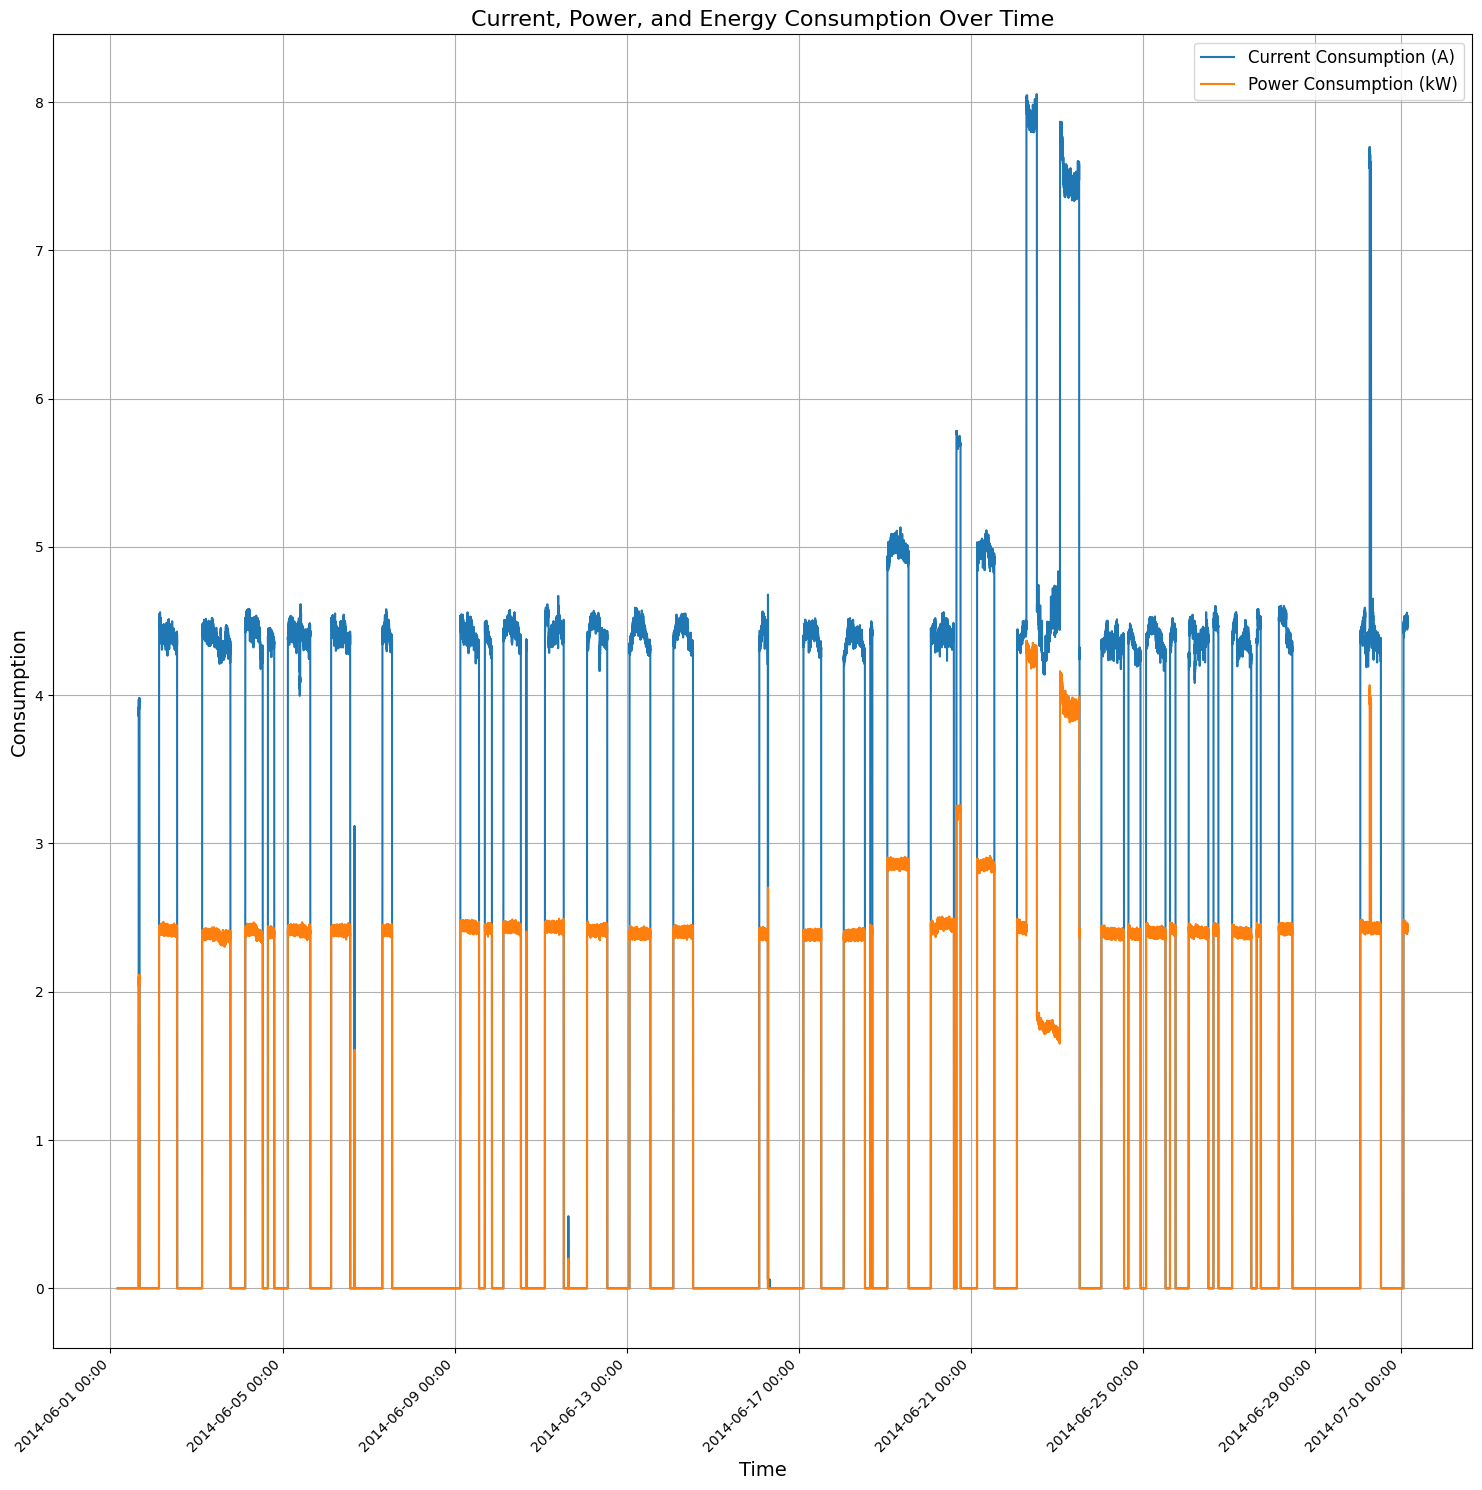

In [ ]:
#Plot Current and Power Consumption
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Plot Current Consumption
ax.plot(unit_current['datetime'], unit_current['value'], label='Current Consumption (A)')

# Plot Power Consumption
ax.plot(unit_power['datetime'], unit_power['value']/1000, label='Power Consumption (kW)')

# Plot Energy Consumption
#ax.plot(unit_energy['datetime'], unit_energy['value']/1000, label='Energy Consumption (kWh)')

# Set labels and title with increased font size
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Consumption', fontsize=14)
ax.set_title('Current, Power, and Energy Consumption Over Time', fontsize=16)

# Improve x-axis readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')

# Add grid and legend
ax.grid(True)
ax.legend(fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



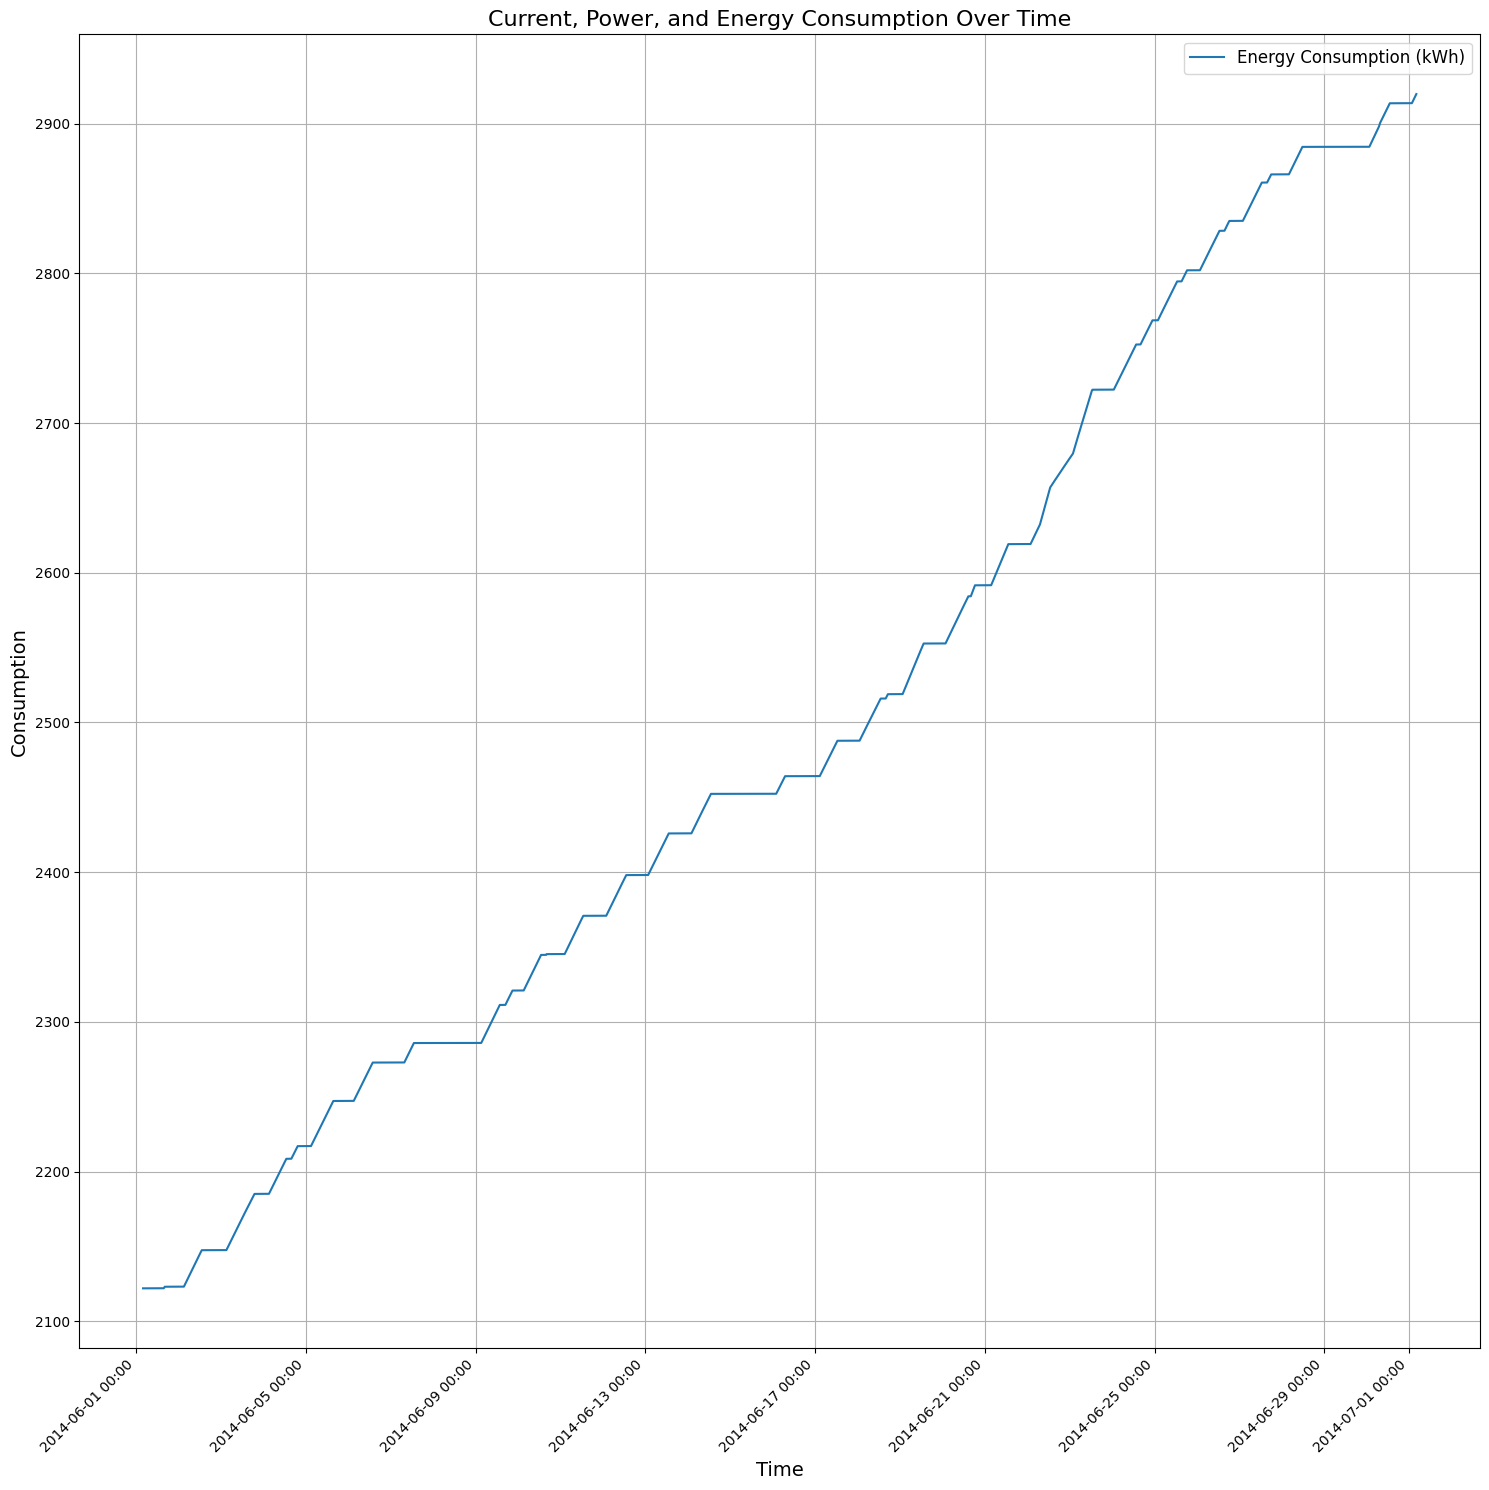

In [ ]:
#Plotting Energy Consumption
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Plot Energy Consumption
ax.plot(unit_energy['datetime'], unit_energy['value']/1000, label='Energy Consumption (kWh)')

# Set labels and title with increased font size
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Consumption', fontsize=14)
ax.set_title('Current, Power, and Energy Consumption Over Time', fontsize=16)

# Improve x-axis readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')

# Add grid and legend
ax.grid(True)
ax.legend(fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

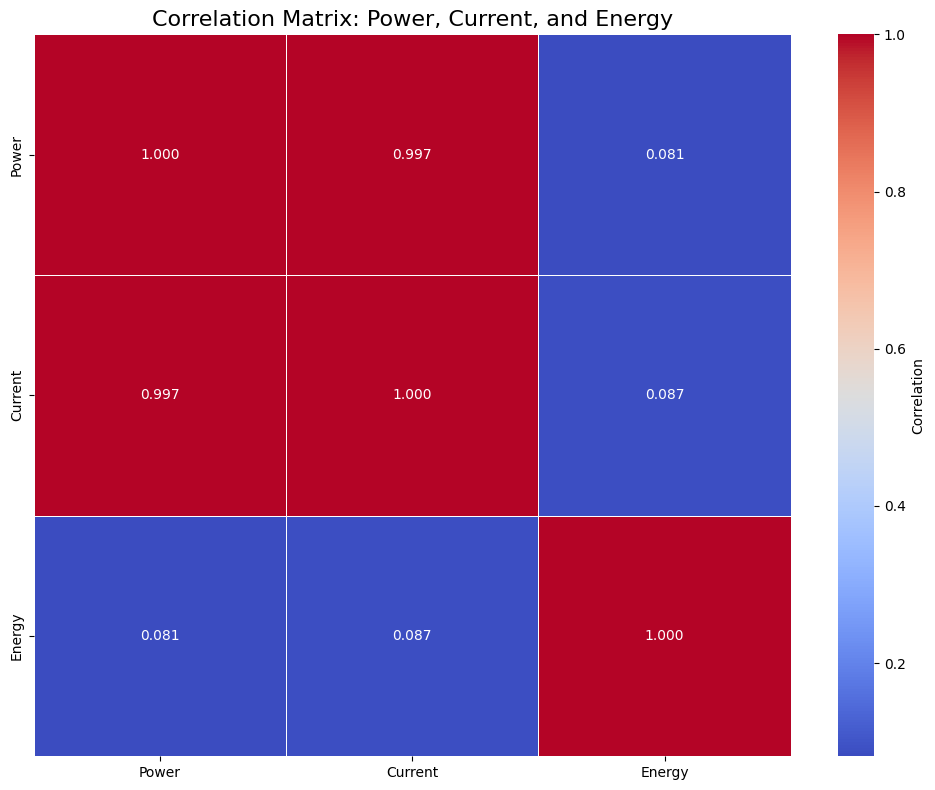

In [ ]:
# Calculate the correlation matrix between power, current and energy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Merge the datasets
merged_df = pd.merge(unit_power, unit_current, on='datetime', suffixes=('_power', '_current'))
merged_df = pd.merge(merged_df, unit_energy, on='datetime')

# Rename columns for clarity
merged_df = merged_df.rename(columns={
    'value_power': 'Power',
    'value_current': 'Current',
    'value': 'Energy'
})

# Compute correlation matrix
corr_matrix = merged_df[['Power', 'Current', 'Energy']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".3f",
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'})

# Customize the plot
plt.title('Correlation Matrix: Power, Current, and Energy', fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


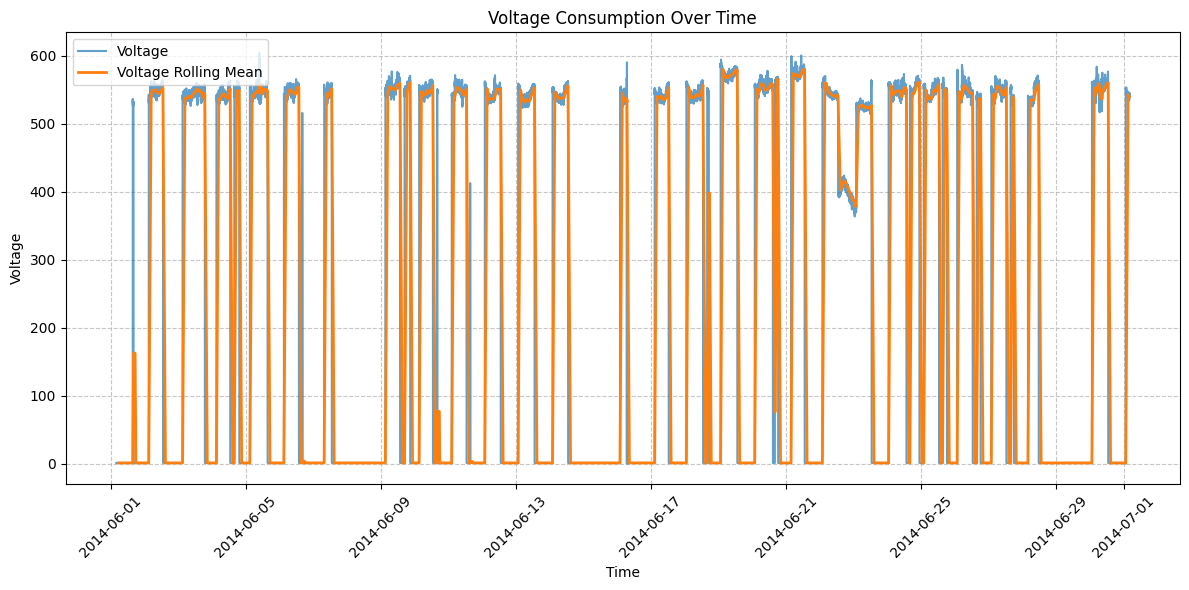

In [ ]:
# Calculate voltage to investigate why correlation between current and power is
# high. The plot shows almost same voltage whenever the unit is running.

import pandas as pd
import matplotlib.pyplot as plt

def calculate_voltage(unit_current, unit_power):
    """
    Calculate voltage from current and power data.

    Args:
    unit_current (pd.DataFrame): DataFrame containing current data
    unit_power (pd.DataFrame): DataFrame containing power data

    Returns:
    pd.DataFrame: DataFrame with datetime and calculated voltage
    """
    df_merged = pd.merge(unit_current, unit_power, on='datetime', suffixes=('_current', '_power'))
    df_merged['value_voltage'] = df_merged['value_power'] / df_merged['value_current']
    return df_merged[['datetime', 'value_voltage']].rename(columns={'value_voltage': 'value'})

def plot_voltage_over_time(unit_voltage, window_size=200):
    """
    Plot raw voltage and rolling mean over time.

    Args:
    unit_voltage (pd.DataFrame): DataFrame containing datetime and voltage values
    window_size (int): Size of the rolling window for mean calculation
    """
    unit_voltage['rolling_mean'] = unit_voltage['value'].rolling(window=window_size).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(unit_voltage['datetime'], unit_voltage['value'], label='Voltage', alpha=0.7)
    plt.plot(unit_voltage['datetime'], unit_voltage['rolling_mean'], label='Voltage Rolling Mean', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title('Voltage Consumption Over Time')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Assuming unit_current and unit_power are already defined
    unit_voltage = calculate_voltage(unit_current, unit_power)
    plot_voltage_over_time(unit_voltage)


<ipython-input-12-8f0d1e9eea8f>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['time_diff'].fillna(0, inplace=True)  # First value has no previous timestamp


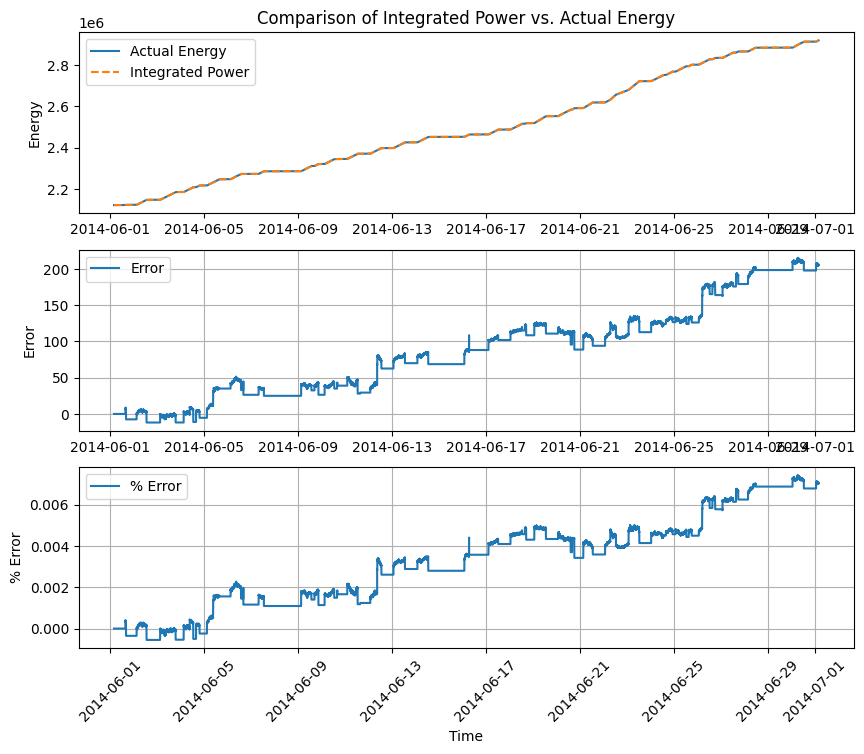

In [ ]:
# Calculate the integral of power and check if it matches with energy
# The plot shows that it matches very well. The small drift is probably due to
# the simple integration rule which we are using.

import numpy as np

merged_df = pd.merge(unit_power, unit_energy, on='datetime', suffixes=('_power', '_energy'))
merged_df['time_diff'] = merged_df['datetime'].diff().dt.total_seconds()
merged_df['time_diff'].fillna(0, inplace=True)  # First value has no previous timestamp

# unit_power['unix_time'] = unit_power['datetime'].astype('int64') // 10**9  # Convert nanoseconds to seconds
# print(unit_power['unix_time'].iloc[0])
# print(unit_power['unix_time'].iloc[1])
# print(np.mean(merged_df['time_diff']))

# Integrated power = Cumulative sum of power * time diff
integrated_power = np.cumsum(merged_df['value_power'] * merged_df['time_diff']) / 3600

# Add initial point
initial_energy = merged_df['value_energy'].iloc[0]
merged_df['integrated_energy'] = integrated_power + initial_energy

# Compute error between integrated and actual energy
merged_df['error'] = merged_df['integrated_energy'] - merged_df['value_energy']

# Percentage error
merged_df['percentage_error'] = (merged_df['error'] / merged_df['value_energy']) * 100

# Plot
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(merged_df['datetime'], merged_df['value_energy'], label='Actual Energy', linestyle='solid')
plt.plot(merged_df['datetime'], merged_df['integrated_energy'], label='Integrated Power', linestyle='dashed')
plt.ylabel('Energy')
plt.legend()
plt.title('Comparison of Integrated Power vs. Actual Energy')

plt.subplot(3, 1, 2)
plt.plot(merged_df['datetime'], merged_df['error'], label='Error', linestyle='solid')
plt.ylabel('Error')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(merged_df['datetime'], merged_df['percentage_error'], label='% Error', linestyle='solid')
plt.xlabel('Time')
plt.ylabel('% Error')
plt.legend()
plt.xticks(rotation=45)
plt.grid()

plt.show()

AHU Power Data collected successfully.


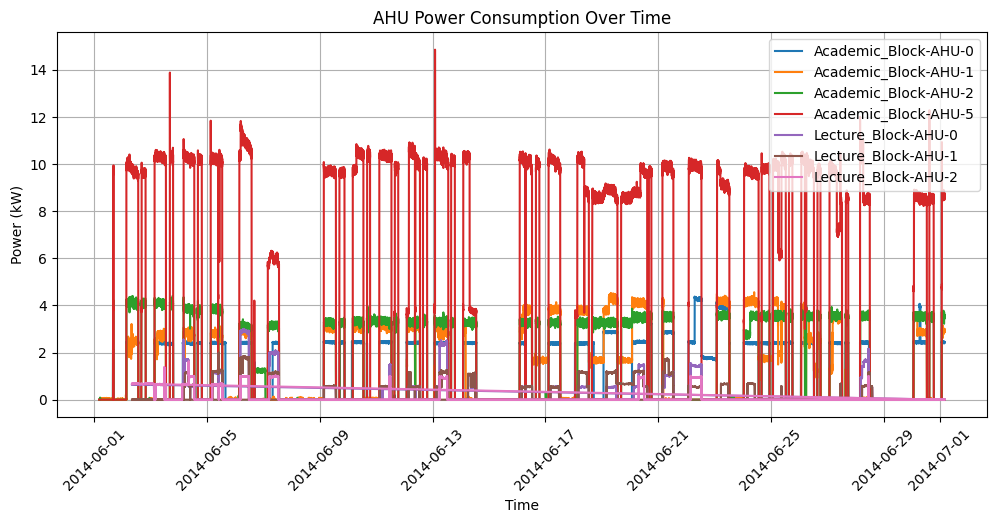

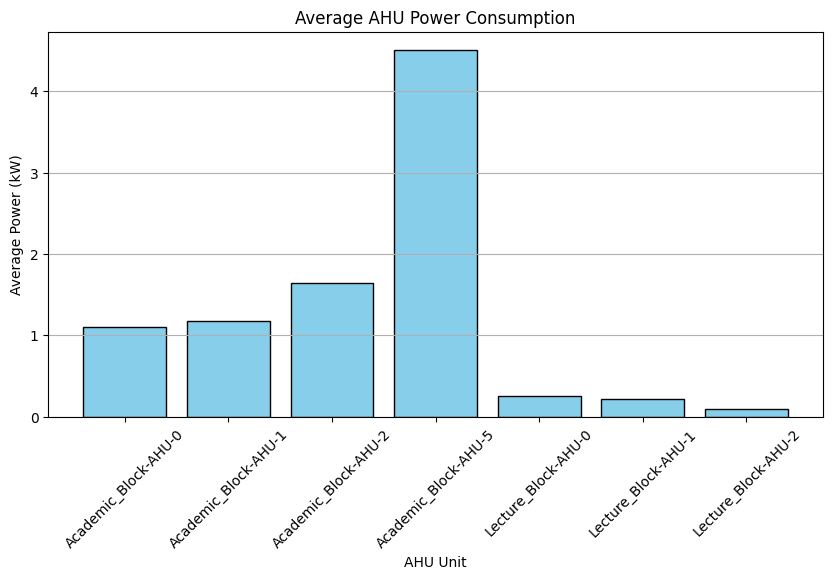


Final Averaged AHU Power Data (1 row per AHU):
                  label     value
0  Academic_Block-AHU-0  1.108174
1  Academic_Block-AHU-1  1.175693
2  Academic_Block-AHU-2  1.645170
3  Academic_Block-AHU-5  4.502706
4   Lecture_Block-AHU-0  0.251965
5   Lecture_Block-AHU-1  0.216648
6   Lecture_Block-AHU-2  0.096148

✅ Saved average power data to: /content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData/AHU_Average_Power.csv
                  label     value
0  Academic_Block-AHU-0  1.108174
1  Academic_Block-AHU-1  1.175693
2  Academic_Block-AHU-2  1.645170
3  Academic_Block-AHU-5  4.502706
4   Lecture_Block-AHU-0  0.251965


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def ensure_column_names(df, default_names=["time", "value"]):
    if len(df.columns) != len(default_names) or not all(df.columns[i] == default_names[i] for i in range(len(default_names))):
        df.columns = default_names
    return df

def collect_ahu_power_data(dataset, blocks=["Academic Block", "Lecture Block"]):
    ahu_power_data = []

    for building in blocks:
        if building not in dataset:
            continue

        for category, units in dataset[building].items():
            if "AHU" not in category:
                continue

            for unit, files in units.items():
                if "Power" not in files:
                    continue

                unit_power = files["Power"].copy()
                unit_power = ensure_column_names(unit_power, ["time", "value"])

                unit_power["datetime"] = pd.to_datetime(unit_power["time"], unit="ms", errors="coerce")
                unit_power.drop(columns=["time"], inplace=True)

                unit_power["label"] = f"{building.replace(' ', '_')}-AHU-{unit}"
                ahu_power_data.append(unit_power)

    return pd.concat(ahu_power_data, ignore_index=True) if ahu_power_data else None

def plot_ahu_power_over_time(ahu_power_df):
    plt.figure(figsize=(12, 5))
    for label, group in ahu_power_df.groupby("label"):
        plt.plot(group["datetime"], group["value"], label=label)

    plt.xlabel("Time")
    plt.ylabel("Power (kW)")
    plt.legend()
    plt.title("AHU Power Consumption Over Time")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

def plot_average_ahu_power(ahu_power_df):
    # Ensure each AHU has only one row in the averaged dataset
    avg_power_df = ahu_power_df.groupby("label", as_index=False)["value"].mean()

    # Bar Plot: Average Power Consumption per AHU
    plt.figure(figsize=(10, 5))
    plt.bar(avg_power_df["label"], avg_power_df["value"], color="skyblue", edgecolor="black")
    plt.xlabel("AHU Unit")
    plt.ylabel("Average Power (kW)")
    plt.title("Average AHU Power Consumption")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

    # Print the averaged power DataFrame (Only one row per AHU)
    print("\nFinal Averaged AHU Power Data (1 row per AHU):")
    print(avg_power_df)

    return avg_power_df

def save_avg_power_df(avg_power_df, folder_path="/content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData"):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_path = os.path.join(folder_path, "AHU_Average_Power.csv")

    # Save the DataFrame as CSV
    avg_power_df.to_csv(file_path, index=False)
    print(f"\n✅ Saved average power data to: {file_path}")

def main(dataset):
    ahu_power_df = collect_ahu_power_data(dataset)

    if ahu_power_df is None:
        print("No AHU Power Data found.")
        return None

    print("AHU Power Data collected successfully.")

    # Convert W to kW before calculating the mean
    ahu_power_df["value"] /= 1000

    plot_ahu_power_over_time(ahu_power_df)
    avg_power_df = plot_average_ahu_power(ahu_power_df)

    # Save avg_power_df to the specified folder
    save_avg_power_df(avg_power_df)

    return avg_power_df  # Return the final DataFrame

# Example Usage
if __name__ == "__main__":
    avg_power_df = main(dataset)  # Ensure 'dataset' is defined before calling this

    if avg_power_df is not None:
        print(avg_power_df.head())  # Print first few rows of the fixed dataset


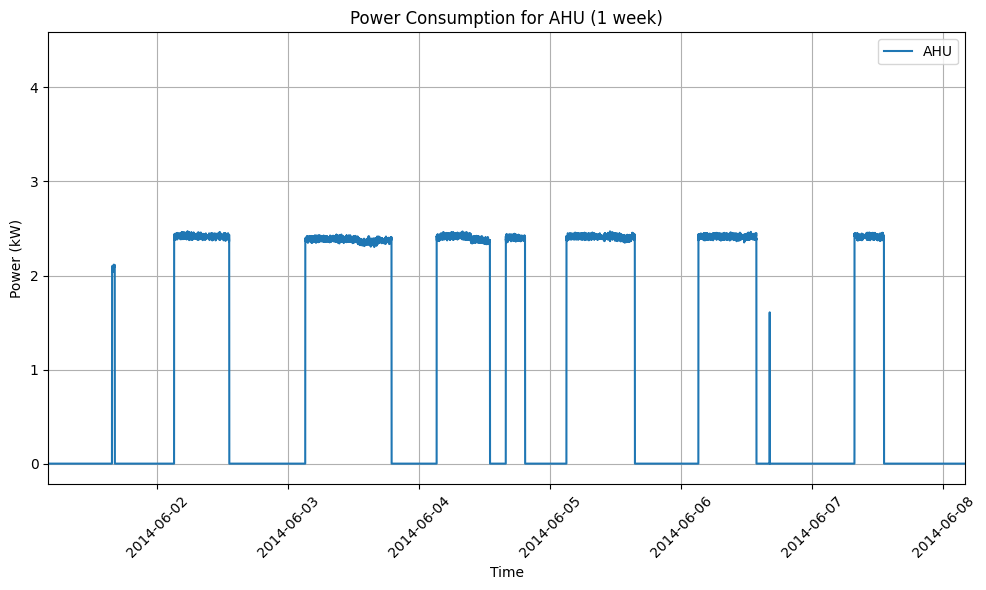

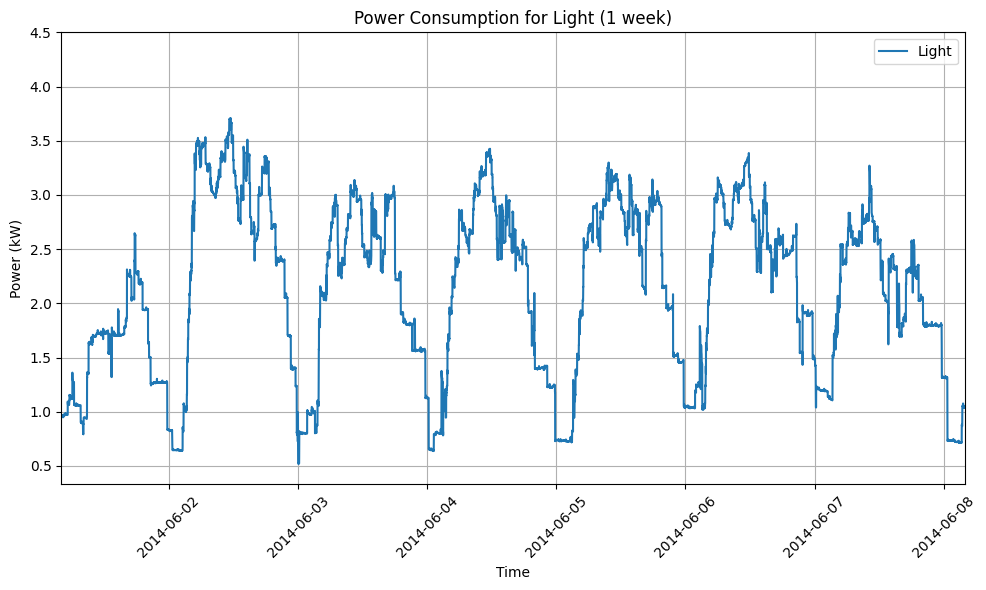

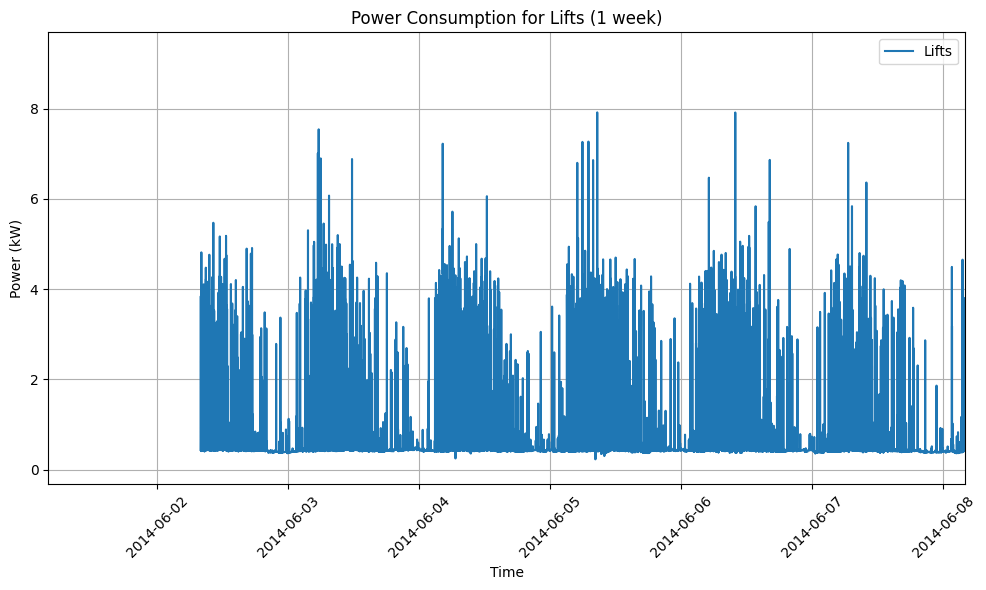

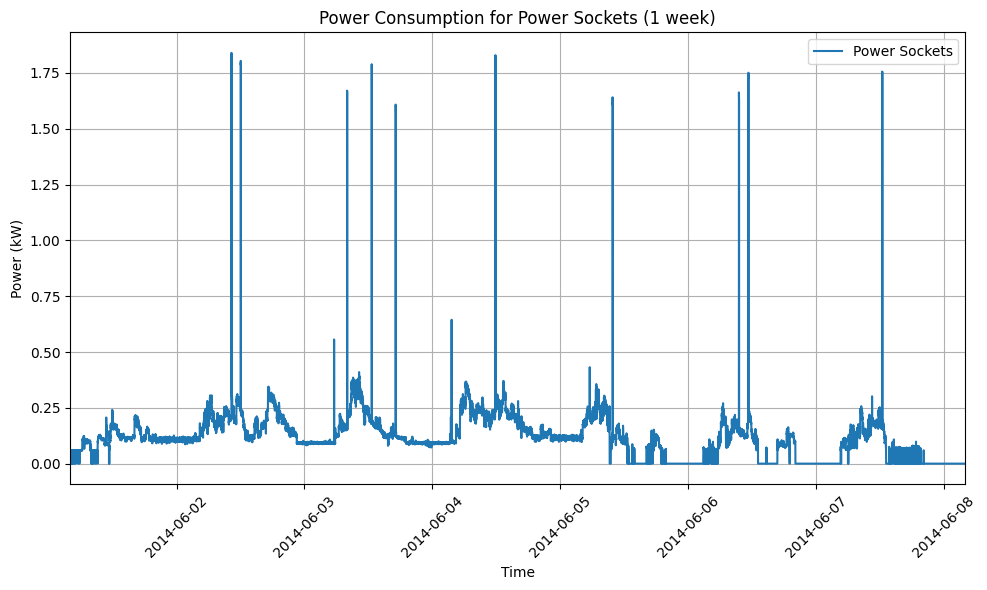

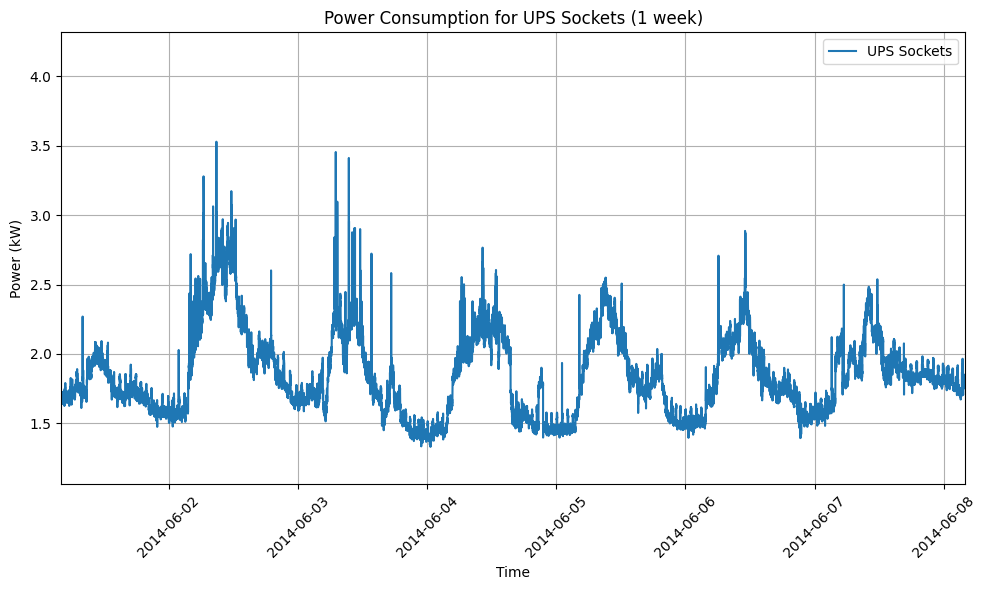

In [ ]:
#Correlation Analysis for Academic Block
import matplotlib.pyplot as plt
import pandas as pd

def get_selected_unit_powers(dataset):
    unit_names = {
        "Academic Block/AHU/0",
        "Academic Block/Light/3",
        "Academic Block/Lifts/0",
        "Academic Block/Power Sockets/3",
        "Academic Block/UPS Sockets/3"
    }

    unit_power_data = {}
    for unit_name in unit_names:
        unit_data = load_unit_data(dataset, unit_name)
        unit_power = unit_data["power"].copy()

        unit_power.columns = ["time", "value"]
        unit_power["datetime"] = pd.to_datetime(unit_power["time"], unit="ms", errors="coerce")
        unit_power.drop(columns=["time"], inplace=True)

        second_part = unit_name.split("/")[1].replace(" ", "_").lower()
        unit_power_data[f"unit_power_{second_part}"] = unit_power

    return unit_power_data

# Load selected unit powers
unit_power_data = get_selected_unit_powers(dataset)

# 1 week zoom data
start_date = unit_power_data["unit_power_power_sockets"]["datetime"].min()
end_date = start_date + pd.Timedelta(days=7)

# Plot each unit's power consumption separately
units = ["ahu", "light", "lifts", "power_sockets", "ups_sockets"]
titles = ["AHU", "Light", "Lifts", "Power Sockets", "UPS Sockets"]

for unit, title in zip(units, titles):
    plt.figure(figsize=(10, 6))
    plt.plot(unit_power_data[f"unit_power_{unit}"]["datetime"],
             unit_power_data[f"unit_power_{unit}"]["value"]/1000,
             label=title)
    plt.ylabel("Power (kW)")
    plt.xlabel("Time")
    plt.title(f"Power Consumption for {title} (1 week)")
    plt.legend()
    plt.grid(True)
    plt.xlim(start_date, end_date)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


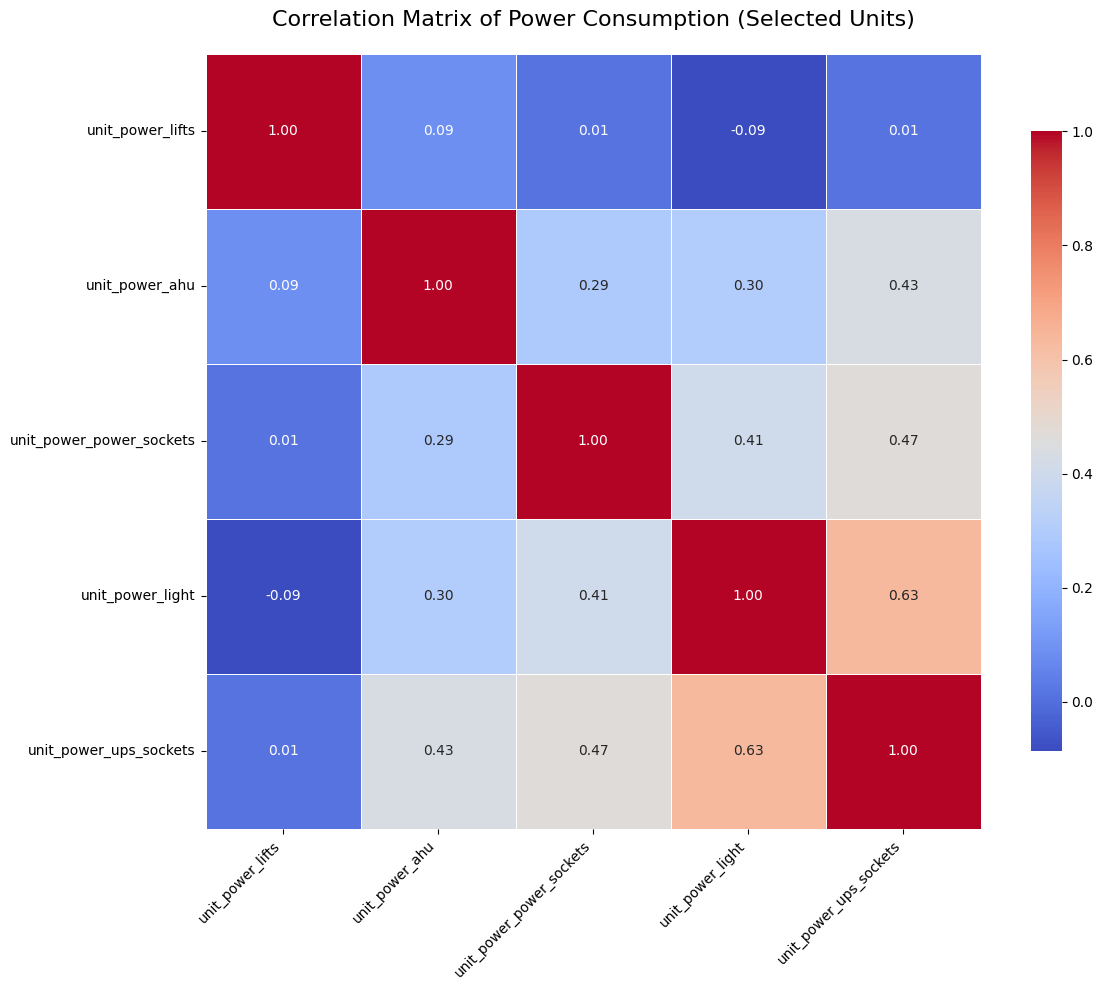

In [ ]:
#Heatmap of Academic Block Power Consumption
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data for correlation matrix calculation
power_df = pd.DataFrame({unit_key: df["value"] for unit_key, df in unit_power_data.items()})

# Compute correlation matrix
corr_matrix = power_df.corr()

# Create and customize the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": .8})

# Customize the plot
plt.title("Correlation Matrix of Power Consumption (Selected Units)", fontsize=16, pad=20)
plt.tight_layout()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


### Analysis on Correlation between Powers of Lift, AHU, Power Sockets, Light and UPS Sockets

Observations
- We see there is a somewhat strong correlation between AHU and Light power. This makes sense because during the work hours both AHU and lights are on
- We see a strong correlation between light and power sockets. This is likely because both are used during daytime
- We see a strong correlation between light and ups sockets. Again, this is because both are used during daytime
- We see weak correlation between lift and other features. This is because lifts are frequently used and switches on/off. So, the periodicity is quite different



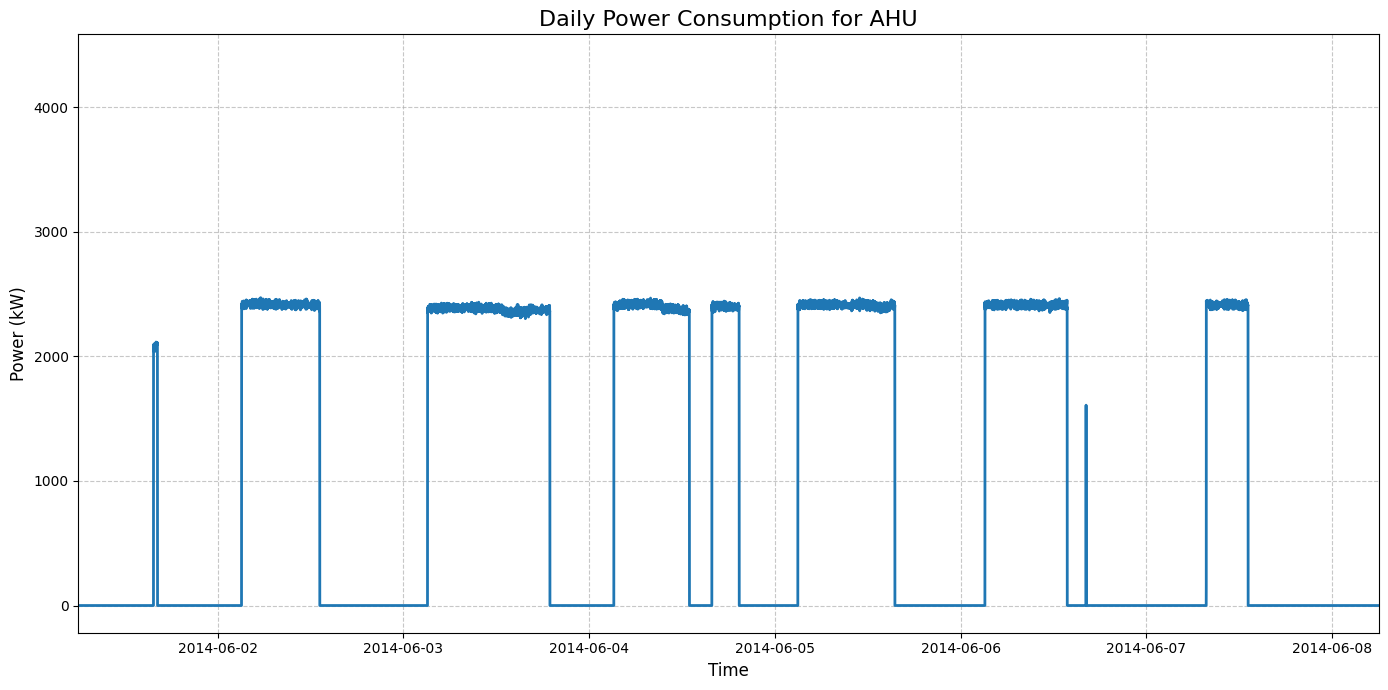

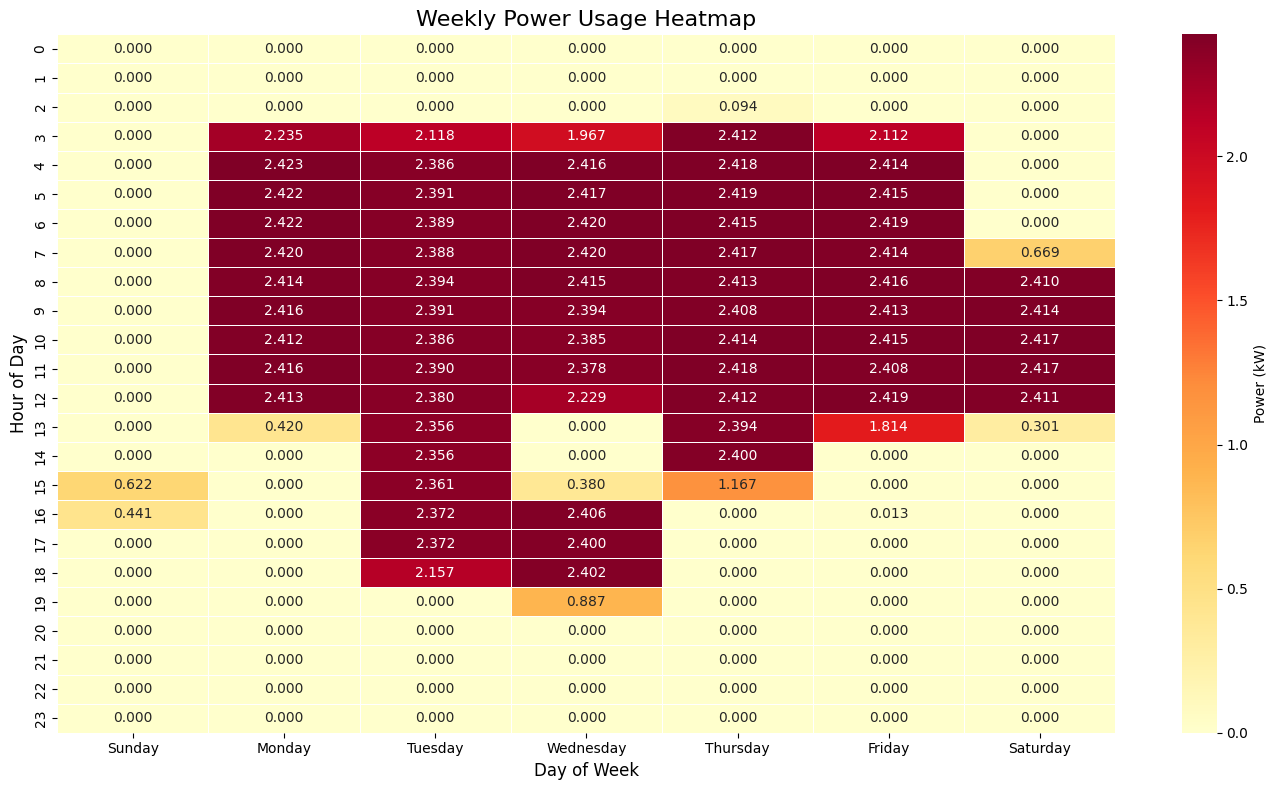

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
UNIT_NAME = "unit_power_ahu"
START_HOUR = 6
DAYS_TO_PLOT = 7

# Data preparation
def prepare_weekly_data(df, start_hour, days_to_plot):
    first_date = df["datetime"].min().normalize()
    start_time = first_date + pd.Timedelta(hours=start_hour)
    end_time = start_time + pd.Timedelta(days=days_to_plot)

    df_weekly = df[(df["datetime"] >= start_time) & (df["datetime"] < end_time)].copy()
    df_weekly["value"] = df_weekly["value"] / 1000  # Divide by 1000
    df_weekly["day"] = df_weekly["datetime"].dt.strftime('%A')  # Day name
    df_weekly["hour"] = df_weekly["datetime"].dt.hour

    return df_weekly, start_time, end_time

# Plotting functions
def plot_daily_power_consumption(df, start_time, end_time):
    plt.figure(figsize=(14, 7))
    plt.plot(df.datetime, df.value, linewidth=2)
    plt.xlim(start_time, end_time)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Power (kW)", fontsize=12)  # Changed from kW to W
    plt.title("Daily Power Consumption for AHU", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_weekly_power_heatmap(df_weekly):
    df_aggregated = df_weekly.groupby(["hour", "day"])["value"].mean().reset_index()
    heatmap_data = df_aggregated.pivot(index="hour", columns="day", values="value")

    # Reorder columns to start from Sunday
    day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    heatmap_data = heatmap_data.reindex(columns=day_order)

    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".3f",  # Changed fmt to .3f
                linewidths=0.5, cbar_kws={'label': 'Power (kW)'})  # Changed from kW to W
    plt.title("Weekly Power Usage Heatmap", fontsize=16)
    plt.xlabel("Day of Week", fontsize=12)
    plt.ylabel("Hour of Day", fontsize=12)
    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Assuming unit_power_data is already loaded
    df = unit_power_data[UNIT_NAME].copy()
    df["value"] = df["value"]
    df_weekly, start_time, end_time = prepare_weekly_data(df, START_HOUR, DAYS_TO_PLOT)

    plot_daily_power_consumption(df, start_time, end_time)
    plot_weekly_power_heatmap(df_weekly)

if __name__ == "__main__":
    main()


# Tableau Data


In [ ]:
# Collect all the AHU data and save in corresponding files

#summarize_data_structure(dataset)

CREATE_TABLEAU_DATA = 0

if CREATE_TABLEAU_DATA == 1:

  unit_names = {
      "Academic Block/AHU/0",
      "Academic Block/AHU/1",
      "Academic Block/AHU/2",
      "Academic Block/AHU/5",
      "Lecture Block/AHU/0",
      "Lecture Block/AHU/1",
      "Lecture Block/AHU/2",
      "Lecture Block/AHU-1/0",
      "Lecture Block/AHU-2/1"
      }

  # location to save files
  drive_path = "/content/drive/MyDrive/AAI520-IoT/FinalProject/TableauData"

  # for loop going through all the AHU units
  df = []
  for unit_name in unit_names:
    print(unit_name)
    unit_data = load_unit_data(dataset, unit_name)
    unit_current = unit_data["current"]
    unit_energy = unit_data["energy"]
    unit_power = unit_data["power"]

    # convert to data frame
    df = pd.DataFrame({
        "Datetime": unit_current["datetime"],
        "Current": unit_current["value"],
        "Energy": unit_energy["value"],
        "Power": unit_power["value"]
    })

    # create filename
    split_names = unit_name.split("/")
    building_name = split_names[0].split(" ")[0]
    category_name = split_names[1]
    unit_number = split_names[2]
    filename = f"{building_name}_{category_name}_{unit_number}.csv"

    # save csv file
    df.to_csv(f"{drive_path}/{filename}", index=False)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def ensure_column_names(df, default_names=["time", "value"]):
    if len(df.columns) != len(default_names) or not all(df.columns[i] == default_names[i] for i in range(len(default_names))):
        df.columns = default_names
    return df

def collect_ahu_power_data(dataset, blocks=["Academic Block", "Lecture Block"]):
    ahu_power_data = []

    for building in blocks:
        if building not in dataset:
            continue

        for category, units in dataset[building].items():
            if "AHU" not in category:
                continue

            for unit, files in units.items():
                if "Power" not in files:
                    continue

                unit_power = files["Power"].copy()
                unit_power = ensure_column_names(unit_power, ["time", "value"])

                unit_power["datetime"] = pd.to_datetime(unit_power["time"], unit="ms", errors="coerce")
                unit_power.drop(columns=["time"], inplace=True)

                unit_power["label"] = f"{building.replace(' ', '_')}-AHU-{unit}"
                ahu_power_data.append(unit_power)

    return pd.concat(ahu_power_data, ignore_index=True) if ahu_power_data else None

def get_ahu_status(ahu_power_df):
    """
    Determines the ON/OFF status of each AHU based on the last recorded power value.
    - ON (1) if the last value is not NaN.
    - OFF (0) if the last value is NaN.
    """
    ahu_status_list = []

    for label, group in ahu_power_df.groupby("label"):
        last_value = group["value"].iloc[-1]  # Get the last recorded power value
        status = 0 if pd.isna(last_value) else 1  # OFF if NaN, otherwise ON
        ahu_status_list.append({"AHU": label, "Status": status})

    return pd.DataFrame(ahu_status_list)  # Convert to DataFrame

def save_ahu_status(ahu_status_df, folder_path="/content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData"):
    """Saves the AHU status data as a CSV file in the specified folder."""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_path = os.path.join(folder_path, "AHU_Status.csv")
    ahu_status_df.to_csv(file_path, index=False)
    print(f"\n✅ Saved AHU status data to: {file_path}")

def main(dataset):
    ahu_power_df = collect_ahu_power_data(dataset)

    if ahu_power_df is None:
        print("No AHU Power Data found.")
        return None

    print("AHU Power Data collected successfully.")

    # Convert W to kW before further processing
    ahu_power_df["value"] /= 1000

    # Get AHU ON/OFF status
    ahu_status_df = get_ahu_status(ahu_power_df)

    # Save AHU Status to CSV
    save_ahu_status(ahu_status_df)

    # Print the AHU status DataFrame
    print("\nFinal AHU Status Data:")
    print(ahu_status_df)

    return ahu_status_df  # Return AHU status DataFrame

# Example Usage
if __name__ == "__main__":
    ahu_status_df = main(dataset)  # Ensure 'dataset' is defined before calling this

    if ahu_status_df is not None:
        print(ahu_status_df.head())  # Print first few rows


AHU Power Data collected successfully.

✅ Saved AHU status data to: /content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData/AHU_Status.csv

Final AHU Status Data:
                    AHU  Status
0  Academic_Block-AHU-0       1
1  Academic_Block-AHU-1       1
2  Academic_Block-AHU-2       1
3  Academic_Block-AHU-5       1
4   Lecture_Block-AHU-0       1
5   Lecture_Block-AHU-1       1
6   Lecture_Block-AHU-2       1
                    AHU  Status
0  Academic_Block-AHU-0       1
1  Academic_Block-AHU-1       1
2  Academic_Block-AHU-2       1
3  Academic_Block-AHU-5       1
4   Lecture_Block-AHU-0       1


In [ ]:
save_folder = "/content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData"

def save_ahu_status_optimized(ahu_status_df, folder_path=save_folder):
    """Saves the AHU status data in an optimized CSV format for faster Tableau extraction."""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_path = os.path.join(folder_path, "AHU_Status_Optimized.csv")

    # Save with optimized settings (no index, UTF-8 encoding, no unnecessary characters)
    ahu_status_df.to_csv(file_path, index=False, encoding="utf-8", quoting=1)

    print(f"\nAHU status file saved to: {file_path}")

# Save the file with optimizations
save_ahu_status_optimized(ahu_status_df)



AHU status file saved to: /content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData/AHU_Status_Optimized.csv


## Prediction of Energy Consumption

### Goal

Our goal is to predict the energy consumption from past data of power, current and energy with an accuracy of 5% or less.

We will demonstrate the performance of the model with Academic Block/AHU/0. Other units in our IoT system can be similarly modeled.

### Approach

Since the dataset is quite large (1 month data at the interval of 30 sec), we will select only 1 week worth of data for the training and validation). Then we will use the model to test the performance of the prediction for the entire month's data.

We first scale the data using MinMaxScalar to facilitate training. We reorganize the data so that we use a sequence length of 4 hours past data and use a prediction horizon of 1 hr.

We use an LSTM model with two layers having 64 and 32 units respectively. We use L2 regularization in the LSTM layers to prevent overfitting. We also use Dropout layers for the same reason.

Note: We have plotted the entire months data in one of the cells below. It shows a regular trend except for an anomaly in the third week where there is higher than usual current and power usage. This is significant to note since the model performance decreases during this period.

### Summmry of Results

The training and validation loss plots shows the model is well trained and there is no overfitting.

The prediction plot for the validation set shows that the 1% accuracy requirement is met.

We also use the same model to show the performance for the months data. As noted above the prediction slightly diverges around week 3. This is due to a data anomaly as highlighted before. However, the accuracy requirement of 5% is still met.

The code developed in the next section shows how anomaly detection can be done. This can be used in a production model to issue a warning that the prediction accuracy may not be good when there is data anomaly.



In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences


In [ ]:
unit_name = "Academic Block/AHU/0"
unit_data = load_unit_data(dataset, unit_name)
unit_current = unit_data["current"]
unit_energy = unit_data["energy"]
unit_power = unit_data["power"]

# convert to data frame
df = pd.DataFrame({
    "Datetime": unit_current["datetime"],
    "Current": unit_current["value"],
    "Energy": unit_energy["value"],
    "Power": unit_power["value"]
})

scaler = MinMaxScaler()
df_scaled = df.copy()

numeric_cols = ["Current", "Energy", "Power"]
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])


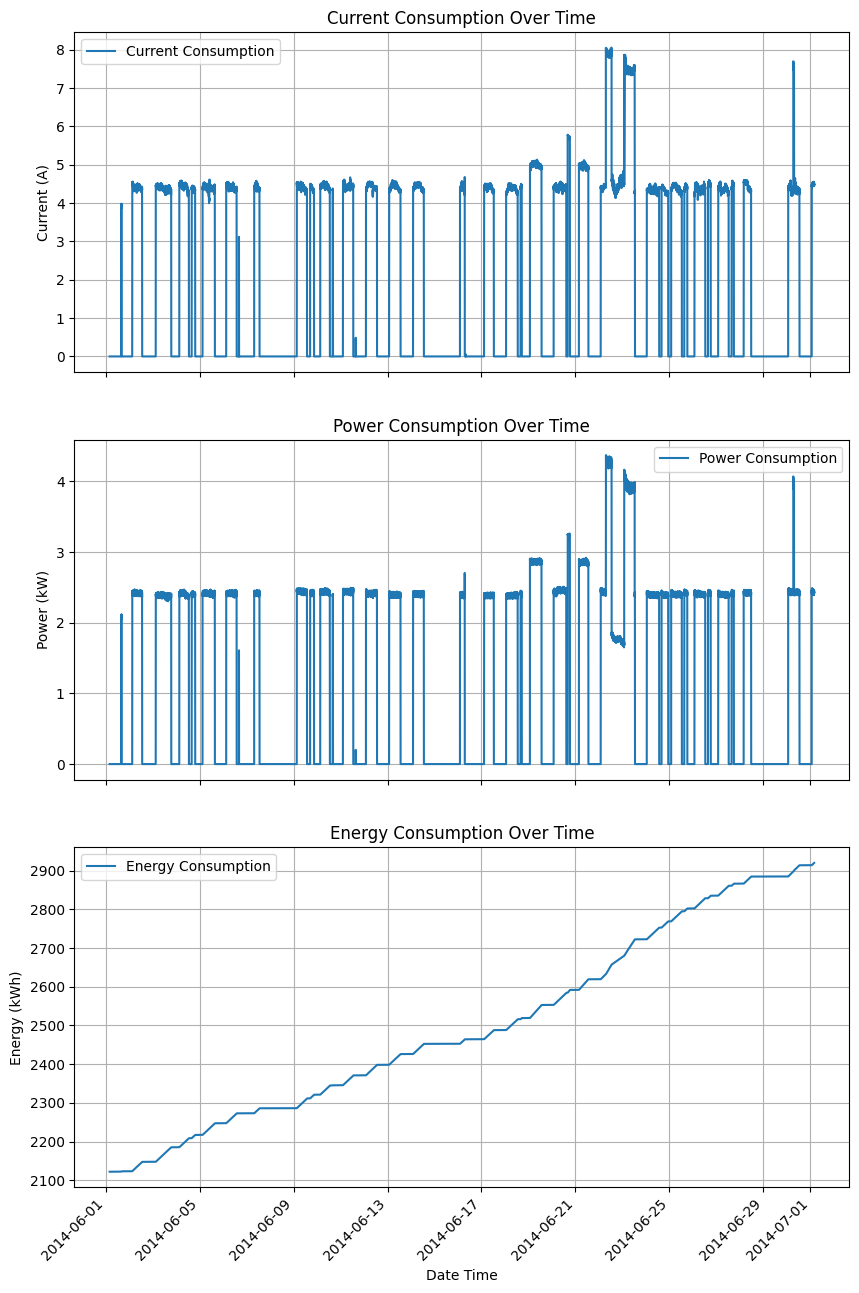

In [ ]:
# Plot for the entire months data showing current, power and energy

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.plot(unit_current['datetime'], unit_current['value'], label='Current Consumption')
plt.ylabel('Current (A)')
plt.gca().tick_params(labelbottom=False)
plt.title('Current Consumption Over Time')
plt.grid()
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(unit_power['datetime'], unit_power['value']/1000, label='Power Consumption')
plt.ylabel('Power (kW)')
plt.gca().tick_params(labelbottom=False)
plt.title('Power Consumption Over Time')
plt.grid()
plt.legend()


plt.subplot(3, 1, 3)
plt.plot(unit_energy['datetime'], unit_energy['value']/1000, label='Energy Consumption')
plt.ylabel('Energy (kWh)')
plt.title('Energy Consumption Over Time')
plt.grid()
plt.legend()
plt.xlabel('Date Time')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
# Training and test dataset

train_size = int(0.8 * len(df_scaled))
train_df = df_scaled.iloc[:train_size]
val_df = df_scaled.iloc[train_size:]

# Print shapes to verify
print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")

Train set size: (68952, 4)
Validation set size: (17239, 4)


In [ ]:
resolution = df_scaled["Datetime"].iloc[1] - df_scaled["Datetime"].iloc[0]
print(f"Resolution: {resolution}")

Resolution: 0 days 00:00:30


In [ ]:
# Create data sequence appropriate for LSTM

seq_arrays = []
seq_labs = []

# We'll use a 4 hours input sequence and a 1 hour predictive horizon
seq_length = 60*4*2  # 4 hours for data resolution of 30 sec
ph = 60*2 # 1 hour for data resolution of 30 sec

# Update the feature columns to include 'Voltage' and 'Global_Intensity' along with 'Global_active_power'
feat_cols = ['Energy', 'Power', 'Current']
data = train_df[feat_cols].values

# Initialization
seq_arrays = []
seq_labs = []

# Create data sequences
for i in range(len(data) - seq_length - ph):
    seq_arrays.append(data[i : i + seq_length])
    seq_labs.append(data[i + seq_length + ph - 1, 0])  # 0 denotes energy

# Convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

# Print statements to check dimensions
print(f"Input sequence shape: {seq_arrays.shape}")  # dhould be (num_samples, 30, 3)
print(f"Output labels shape: {seq_labs.shape}")  # should be (num_samples, 1)


Input sequence shape: (68352, 480, 3)
Output labels shape: (68352,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.regularizers import l2

RUN_LSTM = 0

# define path to save model
model_file = 'LSTM_model1.keras'
model_path = f"/content/drive/MyDrive/AAI530-IoT/FinalProject/LSTM_Model/{model_file}"

if RUN_LSTM == 1:

  # build the network
  nb_features = 3

  model = Sequential()

  #add first LSTM layer
  model.add(LSTM(
          input_shape=(seq_length, nb_features),
          units=64,
          kernel_regularizer=l2(0.01),
          return_sequences=True))
  model.add(Dropout(0.4))

  # add second LSTM layer
  model.add(LSTM(
            units=32,
            kernel_regularizer=l2(0.01),
            return_sequences=False))
  model.add(Dropout(0.4))


  # add dense layer
  model.add(Dense(units=1))

  optimizer = keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

  print(model.summary())

  # fit the network
  history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.2, verbose=2,
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min', restore_best_weights=True),
                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
            )

  # list all data in history
  print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 480, 64)             │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 480, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
110/110 - 10s - 93ms/step - loss: 0.4139 - mse: 0.0059 - val_loss: 0.1132 - val_mse: 1.7061e-04
Epoch 2/100
110/110 - 10s - 87ms/step - loss: 0.0454 - mse: 0.0023 - val_loss: 0.0102 - val_mse: 8.2411e-04
Epoch 3/100
110/110 - 8s - 69ms/step - loss: 0.0056 - mse: 0.0019 - val_loss: 0.0048 - val_mse: 0.0037
Epoch 4/100
110/110 - 11s - 100ms/step - loss: 0.0023 - mse: 0.0016 - val_loss: 0.0057 - val_mse: 0.0053
Epoch 5/100
110/110 - 9s - 86ms/step - loss: 0.0018 - mse: 0.0014 - val_loss: 0.0070 - val_mse: 0.0067
Epoch 6/100
110/110 - 10s - 92ms/step - loss: 0.0016 - mse: 0.0012 - val_loss: 0.0068 - val_mse: 0.0065
Epoch 7/100
110/110 - 10s - 93ms/step - loss: 0.0013 - mse: 0.0010 - val_loss: 0.0037 - val_mse: 0.0035
Epoch 8/100
110/110 - 10s - 93ms/step - loss: 0.0012 - mse: 9.9358e-04 - val_loss: 0.0040 - val_mse: 0.0038
Epoch 9/100
110/110 - 11s - 99ms/step - loss: 0.0010 - mse: 8.2830e-04 - val_loss: 2.5625e-04 - val_mse: 9.3486e-05
Epoch 10/100
110/110 - 10s - 91ms/st

In [ ]:
# Save the training data from previous saved run

SAVE = 0

if SAVE == 1:
  import os
  import pickle

  model_dir = "/content/drive/MyDrive/AAI530-IoT/FinalProject/LSTM_Model"
  if not os.path.exists(model_dir):
    print('Modelpath does not exist ... creating')
    os.makedirs(model_dir)

  model_file = 'LSTM_model1.keras'
  model_path = os.path.join(model_dir, model_file)
  model.save(model_path)
  print(f"Model saved to: {model_path}")

  history_file = 'training_history.pkl'
  history_path = os.path.join(model_dir, history_file)
  with open(history_path, 'wb') as file:
      pickle.dump(history, file)
      print(f"History saved to: {history_path}")

In [ ]:
# Load the training data from saved run

import os
import pickle

# Loading the model and history

model_dir = "/content/drive/MyDrive/AAI530-IoT/FinalProject/LSTM_Model"
model_file = 'LSTM_model1.keras'
model_path = os.path.join(model_dir, model_file)
model = load_model(model_path)

# Check model summary to confirm loading
print(model.summary())

history_file = 'training_history.pkl'
history_path = os.path.join(model_dir, history_file)

with open(history_path, 'rb') as file:
    history = pickle.load(file)
    print(f"History loaded from: {history_path}")
    # list all data in history
    print(history.keys())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 480, 64)             │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 480, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,573 (349.90 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,716 (233.27 KB)

None
History loaded from: /content/drive/MyDrive/AAI530-IoT/FinalProject/LSTM_Model/training_history.pkl
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


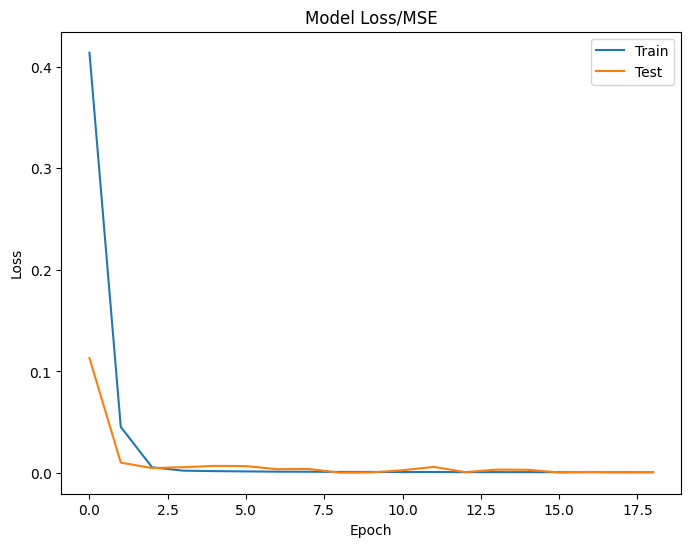

In [ ]:
# Training and validation loss plot

# Check if history is an object with .history attribute or a dictionary
if hasattr(history, 'history'):
    history_dict = history.history
else:
    history_dict = history

plt.figure(figsize=(8, 6))
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss/MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [ ]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
data = val_df[feat_cols].values

for i in range(len(data) - seq_length - ph):
    val_arrays.append(data[i : i + seq_length])
    val_labs.append(data[i + seq_length + ph - 1, 0])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

# Print to check dimensions
print(f"Validation input sequence shape: {val_arrays.shape}")
print(f"Validation output labels shape: {val_labs.shape}")

Validation input sequence shape: (16639, 480, 3)
Validation output labels shape: (16639,)


520/520 - 51s - 98ms/step - loss: 0.0024 - mse: 0.0022

MSE: 0.002247077180072665
520/520 ━━━━━━━━━━━━━━━━━━━━ 50s 95ms/step


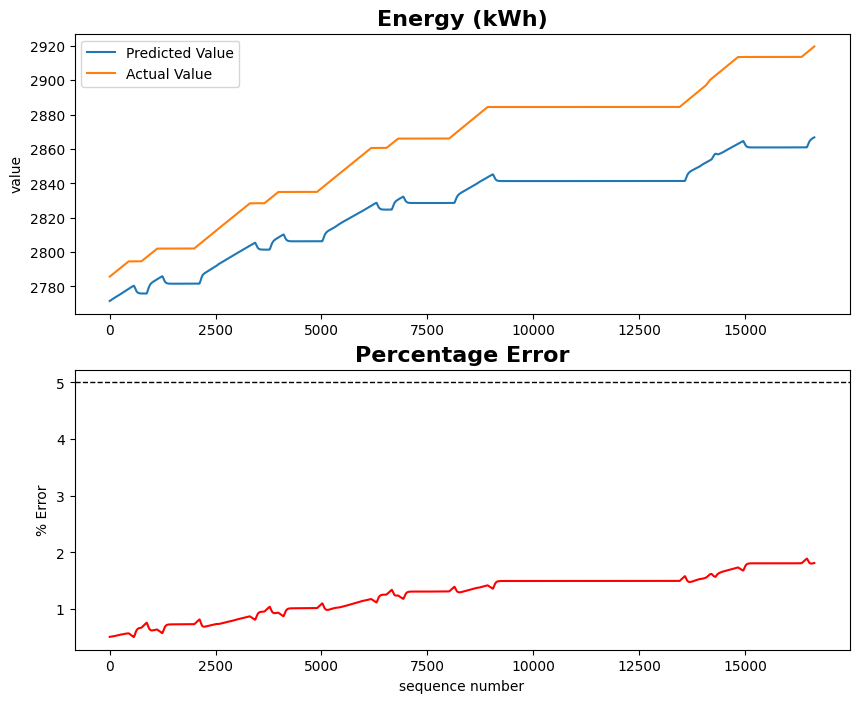

In [ ]:
# MSE score for validation data
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# Prediction vs Truth
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Setup for inverse transform
num_samples = len(y_pred_test)
num_features = 3

# Create empty arrays to hold inverse transformation shape
y_pred_placeholder = np.zeros((num_samples, num_features))
y_true_placeholder = np.zeros((num_samples, num_features))

# Place the predicted values in the correct position
y_pred_placeholder[:, 1] = y_pred_test.flatten()
y_true_placeholder[:, 1] = y_true_test.flatten()

# Inverse transform using the full scaler
y_pred_test_original = scaler.inverse_transform(y_pred_placeholder)[:, 1]  # Energy
y_true_test_original = scaler.inverse_transform(y_true_placeholder)[:, 1]  # Energy

# Compute Percentage Error
percent_error = np.abs((y_pred_test_original - y_true_test_original) / y_true_test_original) * 100

# Plot the predicted vs actual values (inverse transformed)
plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.plot(y_pred_test_original[:]/1000, label='Predicted Value')
plt.plot(y_true_test_original[:]/1000, label='Actual Value')
plt.title('Energy (kWh)', fontsize=16, fontweight='bold')
plt.ylabel('value')
plt.legend()

plt.subplot(212)
plt.plot(percent_error, color='red', label='% Error')
plt.axhline(y=5, color='black', linestyle='--', linewidth=1)  # Reference line at 5%
plt.title('Percentage Error', fontsize=16, fontweight='bold')
plt.ylabel('% Error')
plt.xlabel('sequence number')

plt.show()

In [ ]:
# Create sequences for 1 month data

alldata_arrays = []
alldata_labs = []

#create list of GAP readings starting with a minimum of two readings
data = df_scaled[feat_cols].values
data_datetime = df_scaled["Datetime"].values

for i in range(len(data) - seq_length - ph):
    alldata_arrays.append(data[i : i + seq_length])
    alldata_labs.append(data[i + seq_length + ph - 1, 0])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
alldata_arrays = pad_sequences(alldata_arrays, maxlen=seq_length, padding='pre', dtype='float32')

#convert labels to numpy arrays and floats to appease keras/tensorflow
alldata_labs = np.array(alldata_labs, dtype = object).astype(np.float32)

# Print to check dimensions
print(f"Selected data input sequence shape: {alldata_arrays.shape}")
print(f"Selected data output labels shape: {alldata_labs.shape}")

Selected data input sequence shape: (85591, 480, 3)
Selected data output labels shape: (85591,)


In [ ]:
# Prediction for the entire 1 month data

# MSE score for 1 month data
scores_test = model.evaluate(alldata_arrays, alldata_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# Prediction vs Truth
y_pred_test = model.predict(alldata_arrays)
y_true_test = alldata_labs

# Setup for inverse transform
num_samples = len(y_pred_test)
num_features = 3

# Create empty arrays to hold inverse transformation shape
y_pred_placeholder = np.zeros((num_samples, num_features))
y_true_placeholder = np.zeros((num_samples, num_features))

# Place the predicted values in the correct position
y_pred_placeholder[:, 1] = y_pred_test.flatten()
y_true_placeholder[:, 1] = y_true_test.flatten()

# Inverse transform using the full scaler
y_pred_test_original = scaler.inverse_transform(y_pred_placeholder)[:, 1]  # Energy
y_true_test_original = scaler.inverse_transform(y_true_placeholder)[:, 1]  # Energy

# Compute Percentage Error
percent_error = np.abs((y_pred_test_original - y_true_test_original) / y_true_test_original) * 100


2675/2675 - 262s - 98ms/step - loss: 7.8141e-04 - mse: 6.1865e-04

MSE: 0.0006186540122143924
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 266s 100ms/step


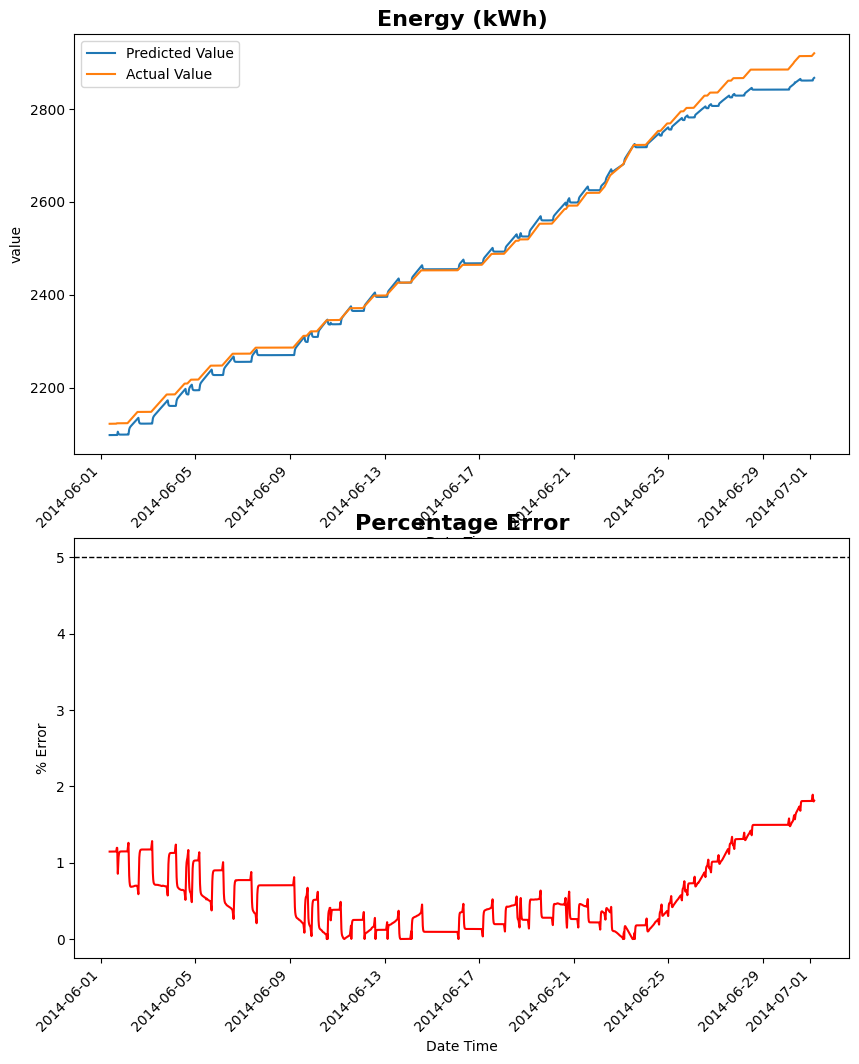

In [ ]:
datetime = df_scaled["Datetime"].iloc[seq_length + ph:]

# Plot the predicted vs actual values (inverse transformed)
plt.figure(figsize=(10, 12))

plt.subplot(2,1,1)
plt.plot(datetime, y_pred_test_original[:]/1000, label='Predicted Value')
plt.plot(datetime, y_true_test_original[:]/1000, label='Actual Value')
plt.title('Energy (kWh)', fontsize=16, fontweight='bold')
plt.ylabel('value')
plt.xlabel('Date Time')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(212)
plt.plot(datetime, percent_error, color='red', label='% Error')
plt.axhline(y=5, color='black', linestyle='--', linewidth=1)  # Reference line at 5%
plt.title('Percentage Error', fontsize=16, fontweight='bold')
plt.ylabel('% Error')
plt.xlabel('Date Time')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
# Save data for Tableau

import pandas as pd
import os

save_folder = "/content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData"
def save_predictions_for_tableau(datetime, y_pred_test_original, y_true_test_original, percent_error, folder_path=save_folder):
    # Create a DataFrame with the required columns
    results_df = pd.DataFrame({
        "Datetime": datetime.values,  # Ensure datetime is properly formatted
        "Predicted Value (kWh)": y_pred_test_original[:] / 1000,
        "Actual Value (kWh)": y_true_test_original[:] / 1000,
        "Percentage Error (%)": percent_error
    })

    # Ensure the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Define the file path
    file_path = os.path.join(folder_path, "Predictions_for_Tableau.csv")

    # Save the DataFrame as a CSV file
    results_df.to_csv(file_path, index=False)

    print(f"\n✅ Predictions saved successfully to: {file_path}")

# Example Usage
save_predictions_for_tableau(datetime, y_pred_test_original, y_true_test_original, percent_error)



✅ Predictions saved successfully to: /content/drive/MyDrive/AAI530-IoT/FinalProject/TableauData/Predictions_for_Tableau.csv



# Anomaly Detection

In [4]:
# Compute rolling average of power consumption data (the 'value' column)
unit_power['rolling_mean'] = unit_power['value'].rolling(window=1000).median()

#
unit_power['rolling_median'] = (unit_power['value'].rolling(window=1000).median() / unit_power['value'].mean())
unit_power['hour'] = unit_power['datetime'].apply(lambda x: x.hour) / 24
unit_power['dayofweek'] = unit_power['datetime'].apply(lambda x: x.dayofweek) / 7
unit_power['sunday'] = unit_power['dayofweek'].apply(lambda x: 1 if (x > 5 / 7) else -1)
unit_power['workhours'] = unit_power['hour'].apply(lambda x: 1 if (x > 4 / 24 and x < 21 / 24) else -1)
unit_power.loc[unit_power['sunday'] > 0, 'workhours'] = -1
unit_power = unit_power.dropna()
df = unit_power.copy().set_index('datetime', inplace=False)
df = df.resample('h').median()

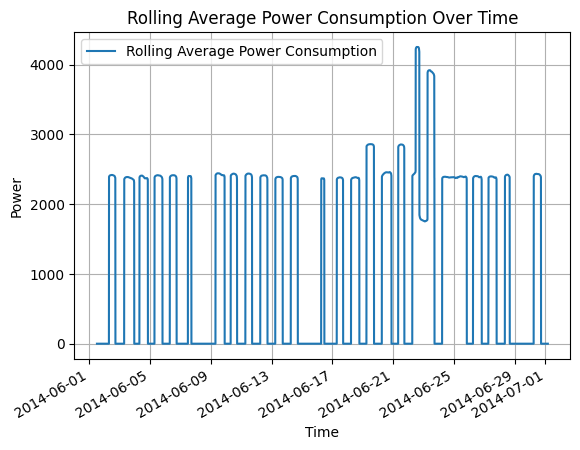

In [6]:
import matplotlib.pyplot as plt

# Plot the rolling average
unit_power.plot(x='datetime', y='rolling_mean', label='Rolling Average Power Consumption')
plt.xlabel('Time')
plt.ylabel('Power')  # Replace with the appropriate unit if known
plt.title('Rolling Average Power Consumption Over Time')
plt.grid()
plt.legend()
plt.show()


In [7]:
def shade_regions(df, condition, shade_color='yellow', alpha=0.3):
    """
    Shades regions on an existing plot where the condition is True.

    Parameters:
    - df: DataFrame with datetime as index
    - condition: Boolean Series indicating where to shade
    - shade_color: Color for the shaded area (default is 'yellow')
    - alpha: Transparency level for the shaded area (default is 0.3)
    """
    start_time = None

    for current_time, cond in zip(df.index, condition):
        if cond and start_time is None:
            start_time = current_time
        elif not cond and start_time is not None:
            plt.axvspan(start_time, current_time, color=shade_color, alpha=alpha)
            start_time = None

    # Handle case where the condition ends at the last point
    if start_time is not None:
        plt.axvspan(start_time, df.index[-1], color=shade_color, alpha=alpha)

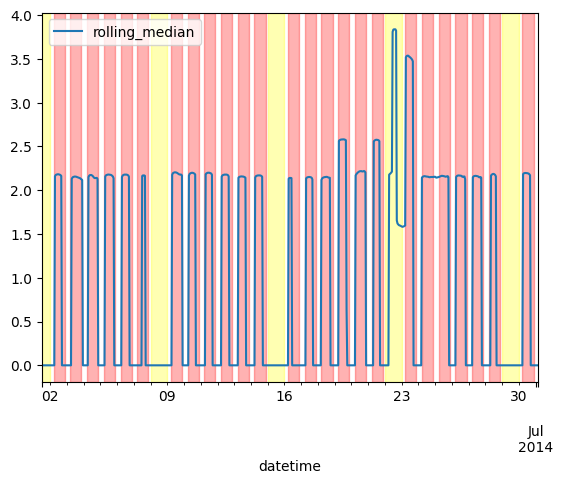

In [8]:
df.plot(y='rolling_median')
shade_regions(df, df['sunday'] > 0)
shade_regions(df, df['workhours'] > 0, shade_color='red')

### Method 1: Isolation Forest

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Isolation Forest Model
# Features to be used
features = ['rolling_median', 'hour', 'dayofweek', 'sunday', 'workhours']

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators = 24*7*2, contamination=0.05)  # contamination=expected anomaly percentage
df['anomaly_score'] = iso_forest.fit_predict(df[features])


<Figure size 1500x600 with 0 Axes>

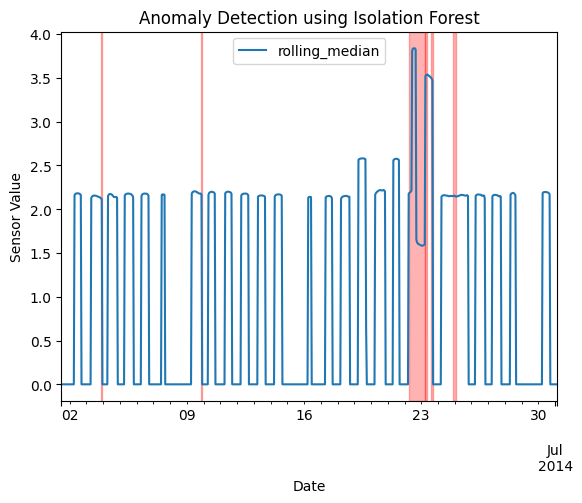

In [ ]:
# 3. Visualization
plt.figure(figsize=(15, 6))

# Plot the data
df.plot(y='rolling_median')
shade_regions(df, df['anomaly_score'] < 0, shade_color='red')

# # Formatting
plt.xlabel('Date')
plt.ylabel('Sensor Value')
plt.title('Anomaly Detection using Isolation Forest')
plt.legend()

plt.show()

### Analysis of Anomaly Detection

The first two spikes are due to longer duration of usage. The first spike was on:

a) 2014-06-03 21:00:00 (1st week)

b) 2014-06-09 21:00:00 (2nd week)

As you can see, on Day 3 (2014-06-03), the power usage was longer than normal which creates the spike. Similarly, it can be shown that the 2nd anomaly was due to the same reason.

The anomaly later in the month was due to high than normal usage of power.

First Two Anomalies Detected at: DatetimeIndex(['2014-06-03 21:00:00', '2014-06-03 22:00:00',
               '2014-06-09 21:00:00', '2014-06-22 06:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


<ipython-input-14-ef51fdf3d381>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(hour)}:00" for hour in ax.get_xticks()])  # Format as HH:00
<ipython-input-14-ef51fdf3d381>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(hour)}:00" for hour in ax.get_xticks()])  # Format as HH:00
<ipython-input-14-ef51fdf3d381>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(hour)}:00" for hour in ax.get_xticks()])  # Format as HH:00
<ipython-input-14-ef51fdf3d381>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(hour)}:00" for hour in ax.get_xticks()])  # Form

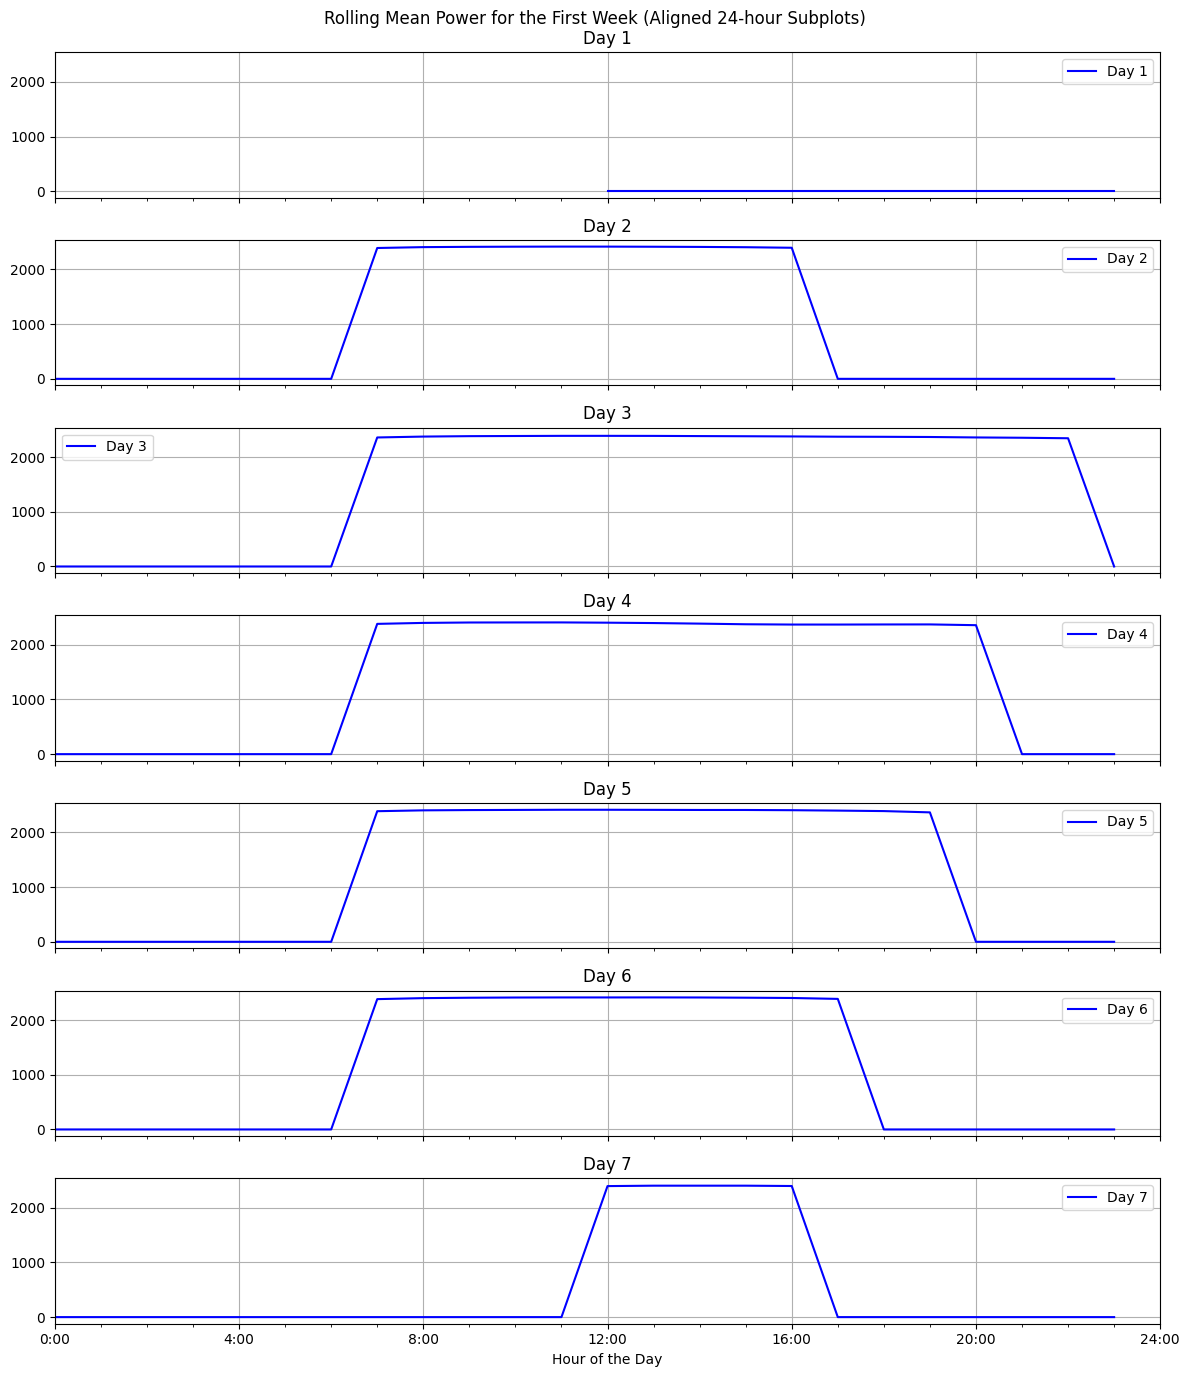

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Find the First Two Spikes in Anomaly
anomalies = df[df['anomaly_score'] < 0].index[:4]
print("First Two Anomalies Detected at:", anomalies)

# 2. Plot the Rolling Mean Power for the First Week with 24-hour Subplots
first_day = df.index.min().normalize()  # Get midnight of the first day
fig, axes = plt.subplots(nrows=7, figsize=(12, 14), sharex=True, sharey=True)

for i in range(7):
    day_start = first_day + pd.Timedelta(days=i)  # Start of current day
    day_end = day_start + pd.Timedelta(days=1)  # End of current day

    daily_data = df[(df.index >= day_start) & (df.index < day_end)]

    ax = axes[i]
    ax.plot(daily_data.index.hour + daily_data.index.minute / 60,
            daily_data['rolling_mean'],
            label=f'Day {i+1}', color='blue')

    ax.set_title(f"Day {i+1}")
    ax.legend()
    ax.grid(True)

    # Set x-axis to 24-hour format
    ax.set_xlim(0, 24)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))  # Tick every 4 hours
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # Minor ticks every 1 hour
    ax.set_xticklabels([f"{int(hour)}:00" for hour in ax.get_xticks()])  # Format as HH:00

# Formatting
plt.xlabel('Hour of the Day')
plt.suptitle('Rolling Mean Power for the First Week (Aligned 24-hour Subplots)')
plt.tight_layout()
plt.show()


### Method 2: SARIMAX

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example setup: ensure 'datetime' is a datetime type and set it as the index
df = unit_power.copy().dropna()
df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure it's datetime if not already
df.set_index('datetime', inplace=True)


# Make sure the data is sorted by datetime
df.sort_index(inplace=True)

#
df['rolling_mean'] = unit_power['value'].rolling(window=1000).median()

In [ ]:
# Suppose each row represents daily data and we suspect weekly seasonality (m=7).
# We'll try a SARIMA with (1,1,1) for non-seasonal and (1,1,1,7) for seasonal.
# Adjust these based on your data's frequency and patterns.

model = SARIMAX(
    df['rolling_mean'],
    order=(1, 1, 1),          # p,d,q
    seasonal_order=(1, 1, 1, 7),  # P,D,Q,m
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fitted values
df['fitted'] = results.fittedvalues

# Residuals
df['residuals'] = unit_power['rolling_mean'] - df['fitted']

In [ ]:
# Calculate the standard deviation of residuals
resid_std = np.std(df['residuals'])

# Define threshold (3-sigma rule in this example)
threshold = 3 * resid_std

# Identify anomalies
df['anomaly'] = (np.abs(df['residuals']) > threshold)


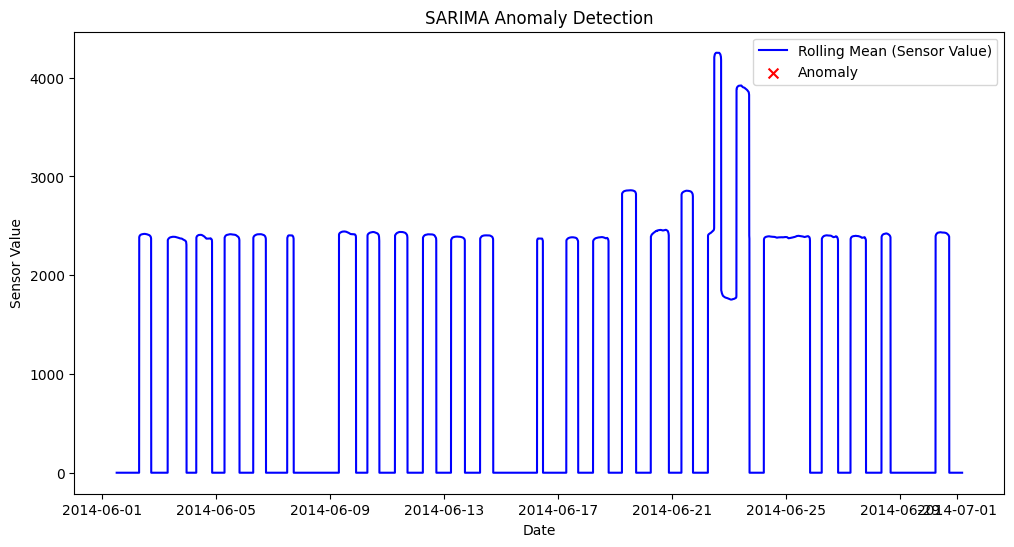

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, unit_power['rolling_mean'], label='Rolling Mean (Sensor Value)', color='blue')

# Mark anomalies in red
anomaly_points = df[df['anomaly']]
plt.scatter(
    anomaly_points.index,
    anomaly_points['rolling_mean'],
    color='red',
    marker='x',
    s=50,
    label='Anomaly'
)

plt.title('SARIMA Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Sensor Value')
plt.legend()

plt.show()

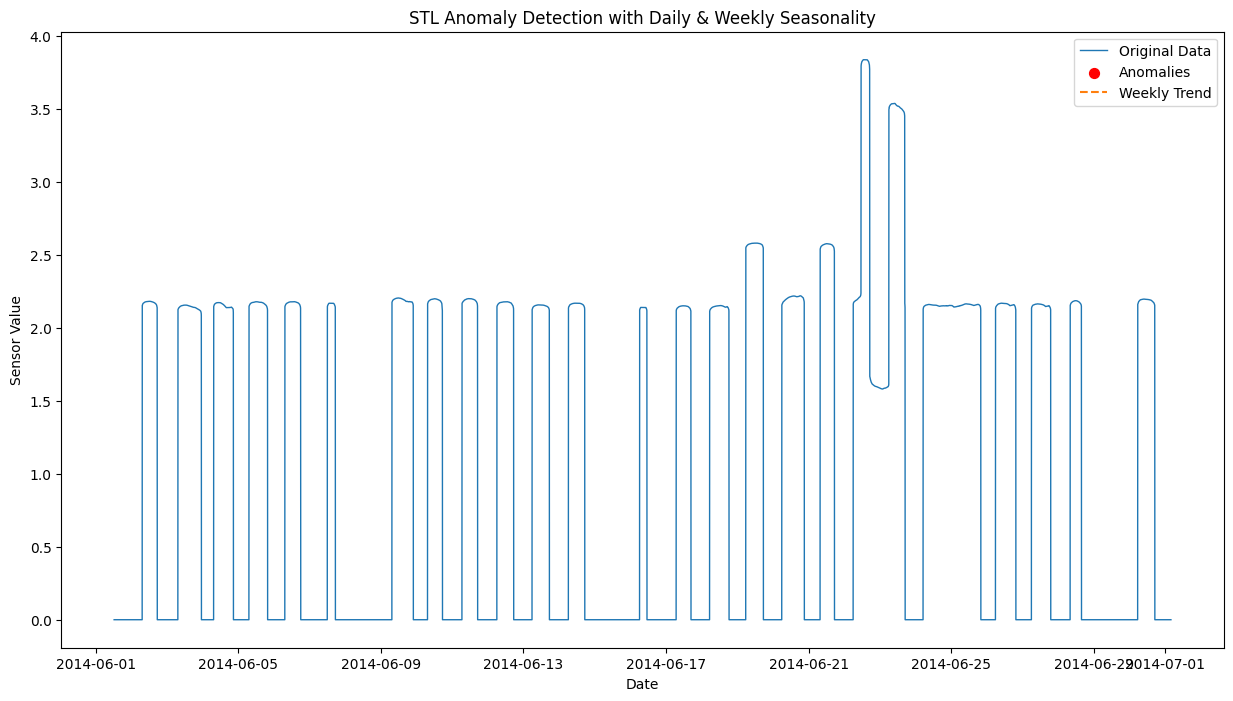

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Assuming combined_data contains datetime index and 'value' column

# 1️⃣ First STL Decomposition for Weekly Seasonality (Period = 168 hours)
stl_weekly = STL(unit_power['rolling_median'], period=168)  # Weekly period for hourly data
result_weekly = stl_weekly.fit()

# Extract trend, seasonal, and residual components
df['trend_weekly'] = result_weekly.trend
df['seasonal_weekly'] = result_weekly.seasonal
df['residual_weekly'] = result_weekly.resid

# 2️⃣ Second STL Decomposition for Daily Seasonality (Period = 24 hours)
# Apply STL on the residuals from the first decomposition
stl_daily = STL(df['residual_weekly'], period=24)  # Daily period
result_daily = stl_daily.fit()

df['seasonal_daily'] = result_daily.seasonal
df['residual_final'] = result_daily.resid  # Final residuals for anomaly detection

# 3️⃣ Anomaly Detection
threshold = 2.5 * np.std(df['residual_final'])  # 3 standard deviations as threshold
df['anomaly'] = np.abs(df['residual_final']) > threshold

# 4️⃣ Plotting
plt.figure(figsize=(15, 8))

# Plot original data
plt.plot(df.index, df['rolling_median'], label='Original Data', linewidth=1)

# Highlight anomalies
anomalies = df[df['anomaly']]
plt.scatter(anomalies.index, anomalies['rolling_median'], color='red', label='Anomalies', s=50, zorder=5)

# Overlay the weekly trend for reference
plt.plot(df.index, df['trend_weekly'], label='Weekly Trend', linestyle='--')

# Formatting
plt.xlabel('Date')
plt.ylabel('Sensor Value')
plt.title('STL Anomaly Detection with Daily & Weekly Seasonality')
plt.legend()

plt.show()

### Method 3: One Class SVM

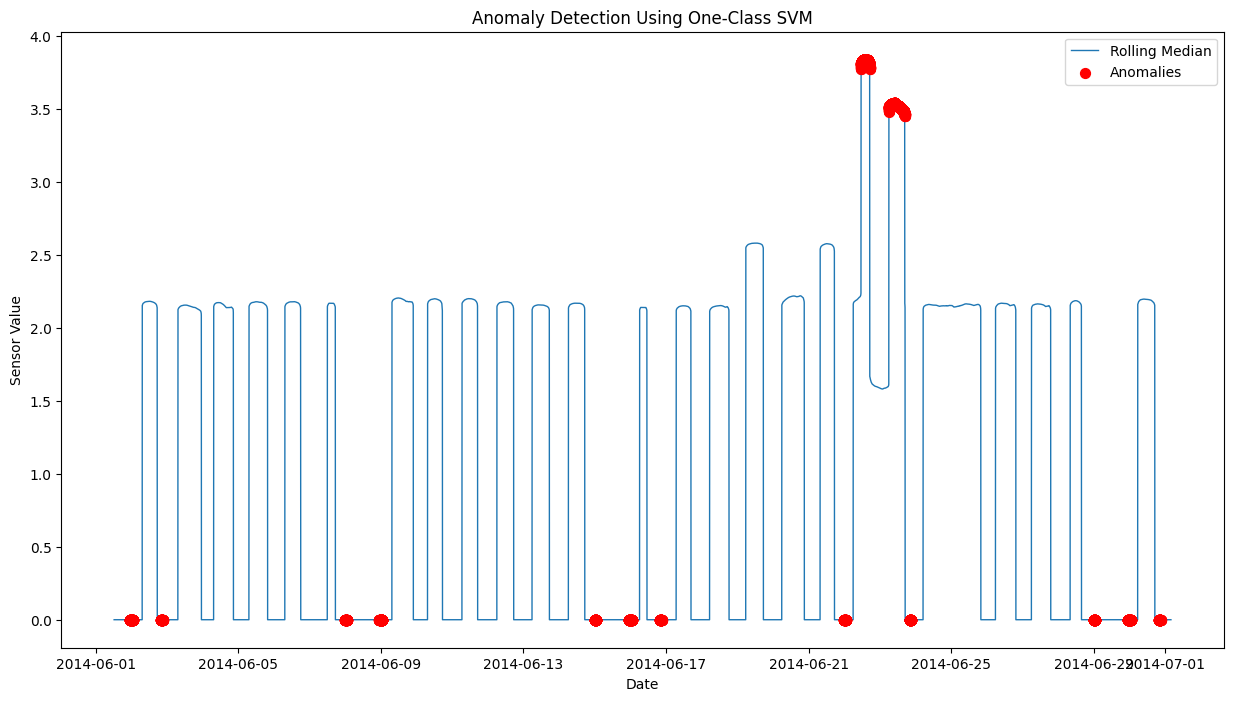

In [ ]:
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import numpy as np

features = ['rolling_median', 'hour', 'dayofweek', 'sunday', 'workhours']

oc_svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)  # gamma & nu can be fine-tuned
df['svm_anomaly_score'] = oc_svm.fit_predict(df[features])

# -1 indicates an anomaly, 1 indicates normal
df['anomaly'] = df['svm_anomaly_score'] == -1

# 4️⃣ Plotting the Results
plt.figure(figsize=(15, 8))

# Plot the rolling median
plt.plot(df.index, unit_power['rolling_median'], label='Rolling Median', linewidth=1)

# Highlight anomalies detected by SVM
anomalies = df[df['anomaly']]
plt.scatter(anomalies.index, anomalies['rolling_median'], color='red', label='Anomalies', s=50, zorder=5)

# Formatting
plt.xlabel('Date')
plt.ylabel('Sensor Value')
plt.title('Anomaly Detection Using One-Class SVM')
plt.legend()

plt.show()